# <center>Projet 7 - Implémentez un modèle de scoring

## Introduction

Notre mission consiste à développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

**Objectifs**

- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

Ce notebook traite la partie nettoyage, feature engineering et feature selection du dataset Home credit default risk :

**Source :** 
Les fonctions d'aggrégation et feature engineering ont été reprises du notebook : [Lien](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output).

# 1. Importation des modules et données

In [3]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Encodage variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Warnings
warnings.filterwarnings('ignore')

In [4]:
#Affichage des lignes et colonnes
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# 2. Fonctions

In [5]:
def load_all_tables(directory_path='', verbose=True):
    '''
    Function to load all the tables required
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not

    '''
    if verbose:
        print("Chargement des jeux de donnees...")
        print("--------------------------------------------------------------------")
        start = datetime.now()

    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Fichier application_train.csv chargé -> dataframe : application_train")

    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Fichier application_test.csv chargé -> dataframe : application_test")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Fichier bureau.csv chargé -> dataframe : bureau")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Fichier bureau_balance.csv chargé -> dataframe : bureau_balance")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Fichier credit_card_balance.csv chargé -> dataframe : cc_balance")

    installments_payments = pd.read_csv(
        directory_path + 'installments_payments.csv')
    if verbose:
        print(
            "Fichier installments_payments.csv chargé -> dataframe : installments_payments")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance")

    HomeCredit_columns_description = pd.read_csv(
        directory_path +
        'HomeCredit_columns_description.csv',
        encoding='cp1252')
    del HomeCredit_columns_description['Unnamed: 0']
    if verbose:
        print("Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description")

    previous_application = pd.read_csv(
        directory_path + 'previous_application.csv')
    if verbose:
        print("Fichier previous_application.csv chargé -> dataframe : previous_application")

    if verbose:
        print("--------------------------------------------------------------------")
        print(
            f'Chargement des 9 jeux de donnees terminée en {datetime.now() - start} secondes')

    return application_train, application_test, bureau, bureau_balance, \
        cc_balance, installments_payments, POS_CASH_balance, previous_application, \
        HomeCredit_columns_description

In [6]:
def get_missing_values(df_work, pourcentage, affiche_heatmap, retour=False):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.product(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes : {nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

    if retour:
        return table

In [7]:
def feature_engineering_application(data):
    '''
    FEATURE ENGINEERING : création de nouvelles variables.
    Extrait de : https://github.com/rishabhrao1997/Home-Credit-Default-Risk
    Parameters
    ----------
    data : dataframe pour ajout de nouvelles variables, obligatoire.
    Returns
    -------
    None.
    '''

    # -----------------------------------------------------------------------
    # Variables de revenu, de rente et de crédit :  ratio / différence
    # -----------------------------------------------------------------------
    # Ratio : Montant du crédit du prêt / Revenu du demandeur
    data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Annuité de prêt
    data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_ANNUITY'] + 0.00001)
    # Ratio : Annuité de prêt / Revenu du demandeur
    data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Différence : Revenu du demandeur - Annuité de prêt
    data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - \
        data['AMT_ANNUITY']
    # Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé
    # Crédit est supérieur au prix des biens ?
    data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_GOODS_PRICE'] + 0.00001)
    # Différence : Revenu du demandeur - prix des biens pour lesquels le prêt
    # est accordé
    data['INCOME_GOODS_DIFF'] = data['AMT_INCOME_TOTAL'] / \
        data['AMT_GOODS_PRICE']
    # Ratio : Annuité de prêt / Âge du demandeur au moment de la demande
    data['INCOME_AGE_RATIO'] = data['AMT_INCOME_TOTAL'] / (
        data['DAYS_BIRTH'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Âge du demandeur au moment de la
    # demande
    data['CREDIT_AGE_RATIO'] = data['AMT_CREDIT'] / (
        data['DAYS_BIRTH'] + 0.00001)
    # Ratio : Revenu du demandeur / Score normalisé de la source de données
    # externe 3
    data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / \
        (data['EXT_SOURCE_3'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Score normalisé de la source de
    # données externe
    data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / \
        (data['EXT_SOURCE_3'] + 0.00001)
    # Multiplication : Revenu du demandeur
    #                  * heure à laquelle le demandeur à fait sa demande de prêt
    data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * \
        data['HOUR_APPR_PROCESS_START']

    # -----------------------------------------------------------------------
    # Variables sur l'âge
    # -----------------------------------------------------------------------
    # YEARS_BIRTH - Âge du demandeur au moment de la demande DAYS_BIRTH en
    # années
    data['YEARS_BIRTH'] = data['DAYS_BIRTH'] * -1 / 365
    # Différence : Âge du demandeur - Ancienneté dans l'emploi à date demande
    data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    # Ratio : Ancienneté dans l'emploi à date demande / Âge du demandeur
    data['EMPLOYED_AGE_RATIO'] = data['DAYS_EMPLOYED'] / \
        (data['DAYS_BIRTH'] + 0.00001)
    # Ratio : nombre de jours avant la demande où le demandeur a changé de téléphone \
    #         äge du client
    data['LAST_PHONE_BIRTH_RATIO'] = data[
        'DAYS_LAST_PHONE_CHANGE'] / (data['DAYS_BIRTH'] + 0.00001)
    # Ratio : nombre de jours avant la demande où le demandeur a changé de téléphone \
    #         ancienneté dans l'emploi
    data['LAST_PHONE_EMPLOYED_RATIO'] = data[
        'DAYS_LAST_PHONE_CHANGE'] / (data['DAYS_EMPLOYED'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur la voiture
    # -----------------------------------------------------------------------
    # Différence : Âge de la voiture du demandeur -  Ancienneté dans l'emploi
    # à date demande
    data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
    # Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à date
    # demande
    data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / \
        (data['DAYS_EMPLOYED'] + 0.00001)
    # Différence : Âge du demandeur - Âge de la voiture du demandeur
    data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
    # Ratio : Âge de la voiture du demandeur / Âge du demandeur
    data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / \
        (data['DAYS_BIRTH'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur les contacts
    # -----------------------------------------------------------------------
    # Somme : téléphone portable? + téléphone professionnel? + téléphone
    #         professionnel fixe? + téléphone portable joignable? +
    #         adresse de messagerie électronique?
    data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + \
        data['FLAG_WORK_PHONE'] + data['FLAG_CONT_MOBILE'] + \
        data['FLAG_PHONE'] + data['FLAG_EMAIL']

    # -----------------------------------------------------------------------
    # Variables sur les membres de la famille
    # -----------------------------------------------------------------------
    # Différence : membres de la famille - enfants (adultes)
    data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
    # Ratio : nombre d'enfants / Revenu du demandeur
    data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Ratio : Revenu du demandeur / membres de la famille : revenu par tête
    data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / \
        (data['CNT_FAM_MEMBERS'] + 1)

    # -----------------------------------------------------------------------
    # Variables sur la région
    # -----------------------------------------------------------------------
    # Moyenne : moyenne de notes de la région/ville où vit le client * revenu
    # du demandeur
    data['REGIONS_INCOME_MOY'] = (data['REGION_RATING_CLIENT'] +
                                  data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
    # Max : meilleure note de la région/ville où vit le client
    data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(
        data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    # Min : plus faible note de la région/ville où vit le client
    data['REGION_RATING_MIN'] = [min(ele1, ele2) for ele1, ele2 in zip(
        data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    # Moyenne : des notes de la région et de la ville où vit le client
    data['REGION_RATING_MEAN'] = (
        data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
    # Multipication : note de la région/ note de la ville où vit le client
    data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * \
        data['REGION_RATING_CLIENT_W_CITY']
    # Somme : des indicateurs  :
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent ou 0=identique - au niveau de la région)
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent ou 0=identique - au niveau de la région)
    # Indicateur si l'adresse de contact du client ne correspond pas à l'adresse de travail (1=différent ou 0=identique - au niveau de la région).
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent ou 0=identique - au niveau de la ville)
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent ou 0=même - au niveau de la ville).
    # Indicateur si l'adresse de contact du client ne correspond pas à
    # l'adresse de travail (1=différent ou 0=identique - au niveau de la
    # ville).
    data['FLAG_REGIONS_SUM'] = data['REG_REGION_NOT_LIVE_REGION'] + \
        data['REG_REGION_NOT_WORK_REGION'] + \
        data['LIVE_REGION_NOT_WORK_REGION'] + \
        data['REG_CITY_NOT_LIVE_CITY'] + \
        data['REG_CITY_NOT_WORK_CITY'] + \
        data['LIVE_CITY_NOT_WORK_CITY']

    # -----------------------------------------------------------------------
    # Variables sur les sources externes : sum, min, multiplication, max, var, scoring
    # -----------------------------------------------------------------------
    # Somme : somme des scores des 3 sources externes
    data['EXT_SOURCE_SUM'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                   'EXT_SOURCE_3']].sum(axis=1)
    # Moyenne : moyenne des scores des 3 sources externes
    data['EXT_SOURCE_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                    'EXT_SOURCE_3']].mean(axis=1)
    # Multiplication : des scores des 3 sources externes
    data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * \
        data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    # Max : Max parmi les 3 scores des 3 sources externes
    data['EXT_SOURCE_MAX'] = [max(ele1, ele2, ele3) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Min : Min parmi les 3 scores des 3 sources externes
    data['EXT_SOURCE_MIN'] = [min(ele1, ele2, ele3) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Variance : variance des scores des 3 sources externes
    data['EXT_SOURCE_VAR'] = [np.var([ele1, ele2, ele3]) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Scoring : scoring des scores des 3 sources externes, score 1 poids 2...
    data['WEIGHTED_EXT_SOURCE'] = data.EXT_SOURCE_1 * \
        2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4

    # -----------------------------------------------------------------------
    # Variables sur le bâtiment
    # -----------------------------------------------------------------------
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des moyennes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
        'YEARS_BUILD_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
        'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data[
        'LIVINGAREA_AVG'] + data['NONLIVINGAREA_AVG']
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des modes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
        'YEARS_BUILD_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
        'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data[
        'LIVINGAREA_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des médianes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
        'YEARS_BUILD_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
        'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + \
        data['NONLIVINGAREA_MEDI']
    # Multiplication : somme des moyennes des infos sur le bâtiment * revenu
    # du demandeur
    data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * \
        data['AMT_INCOME_TOTAL']
    # Multiplication : somme des modes des infos sur le bâtiment * revenu du
    # demandeur
    data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * \
        data['AMT_INCOME_TOTAL']
    # Multiplication : somme des médianes des infos sur le bâtiment * revenu
    # du demandeur
    data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * \
        data['AMT_INCOME_TOTAL']

    # -----------------------------------------------------------------------
    # Variables sur les défauts de paiements et les défauts observables
    # -----------------------------------------------------------------------
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard) +
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + \
        data['OBS_60_CNT_SOCIAL_CIRCLE']
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard) +
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + \
        data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Multiplication : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard) *
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] * \
        data['DEF_30_CNT_SOCIAL_CIRCLE']
    # Multiplication : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard) *
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] * \
        data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement ou des défauts observables avec 30
    #         DPD (jours de retard) et 60 DPD.
    data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + \
        data['OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard)
    data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard)
    data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur les indicateurs des documents fournis ou non
    # -----------------------------------------------------------------------
    # Toutes les variables DOCUMENT_
    cols_flag_doc = [flag for flag in data.columns if 'FLAG_DOC' in flag]
    # Somme : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_SUM'] = data[cols_flag_doc].sum(axis=1)
    # Moyenne : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_AVG'] = data[cols_flag_doc].mean(axis=1)
    # Variance : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_VAR'] = data[cols_flag_doc].var(axis=1)
    # Ecart-type : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_STD'] = data[cols_flag_doc].std(axis=1)

    # -----------------------------------------------------------------------
    # Variables sur le détail des modifications du demandeur : jour/heure...
    # -----------------------------------------------------------------------
    # Somme : nombre de jours avant la demande de changement de téléphone
    #         + nombre de jours avant la demande de changement enregistré sur la demande
    #         + nombre de jours avant la demande le client où il à
    #           changé la pièce d'identité avec laquelle il a demandé le prêt
    data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + \
        data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
    # Somme : nombre de demandes de renseignements sur le client adressées au Bureau de crédit
    # une heure + 1 jour + 1 mois + 3 mois + 1 an et 1 jour avant la demande
    data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + \
        data['AMT_REQ_CREDIT_BUREAU_MON'] + \
            data['AMT_REQ_CREDIT_BUREAU_QRT'] + \
                data['AMT_REQ_CREDIT_BUREAU_YEAR']
    # Ratio : somme du nombre de demandes de renseignements sur le client adressées au Bureau de crédit
    #         une heure + 1 jour + 1 mois + 3 mois + 1 an et 1 jour avant la demande \
    #         Montant du crédit du prêt
    data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / \
        (data['AMT_CREDIT'] + 0.00001)

    return data


In [8]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number], datetime_is_numeric=True)
    else:
        desc_var = dataframe.describe(include='all', datetime_is_numeric=True)

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [9]:
# AGGREGATION DES VARIABLES STATISTIQUES des VAR QUANTITATIVES

def agg_var_num(dataframe, group_var, dict_agg, prefix):
    """
    Aggregates the numeric values in a dataframe.
    This can be used to create features for each instance of the grouping variable.
    Parameters
    --------
        dataframe (dataframe): the dataframe to calculate the statistics on
        group_var (string): the variable by which to group df
        df_name (string): the variable used to rename the columns
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            some statistics (mean, min, max, sum ...) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in dataframe:
        if col != group_var and 'SK_ID' in col:
            dataframe = dataframe.drop(columns=col)

    group_ids = dataframe[group_var]
    numeric_df = dataframe.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(dict_agg)

    # Ajout suffix mean, sum...
    agg.columns = ['_'.join(tup).strip().upper()
                   for tup in agg.columns.values]

    # Ajout du prefix bureau_balance pour avoir une idée du fichier
    agg.columns = [prefix + '_' + col
                   if col != group_var else col
                   for col in agg.columns]

    agg.reset_index(inplace=True)

    return agg

In [10]:
# AGGREGATION DES VARIABLES STATISTIQUES des VAR QUALITATIVES

def agg_var_cat(dataframe, group_var, prefix):
    '''
        Aggregates the categorical features in a child dataframe
        for each observation of the parent variable.
        
        Parameters
        --------
        - dataframe        : pandas dataframe
                    The dataframe to calculate the value counts for.
            
        - parent_var : string
                    The variable by which to group and aggregate 
                    the dataframe. For each unique value of this variable, 
                    the final dataframe will have one row
            
        - prefix    : string
                    Variable added to the front of column names 
                    to keep track of columns

        Return
        --------
        categorical : pandas dataframe
                    A dataframe with aggregated statistics for each observation 
                    of the parent_var
                    The columns are also renamed and columns with duplicate values 
                    are removed.
    '''
    
    # Select the categorical columns
    categorical = pd.get_dummies(dataframe.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = dataframe[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (prefix, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    # _, idx = np.unique(categorical, axis = 1, return_index = True)
    # categorical = categorical.iloc[:, idx]
    
    return categorical

In [11]:
#SUPPRESSION DES VARIABLES FORTEMENT CORRELEES

def suppr_var_colineaire(dataframe, seuil=0.8):
    '''
    Récupération de la liste des variables fortement corrélées supérieur
    au seuil transmis.
    Parameters
    ----------
    dataframe : dataframe à analyser, obligatoire.
    seuil : le seuil de colinéarité entre les variables (0.8 par défaut).
    Returns
    -------
    cols_corr_a_supp : liste des variables à supprimer.
    '''
    
    # Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
    # les corrélations positives et négatives séparément
    corr = dataframe.corr().abs()
    # On ne conserve que la partie supérieur à la diagonale pour n'avoir
    # qu'une seule fois les corrélations prisent en compte (symétrie axiale)
    corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                               .astype(np.bool))
    
    # Variables avec un coef de Pearson > 0.8?
    cols_corr_a_supp = [var for var in corr_triangle.columns
                        if any(corr_triangle[var] > seuil)]
    print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
    for var in cols_corr_a_supp:
        print(var)
        
    return cols_corr_a_supp

In [12]:
def get_missing_values_sup_seuil(df_work, seuil=90):
    """Retourne les variables qui ont plus que seuil% de valeurs manquantes.
       @param in : df_work dataframe obligatoire
                   seuil : seuil (90% par défaut)
       @param out : cols_nan_a_suppr : liste des variables à supprimer
    """

    values = df_work.isnull().sum()
    percentage = 100 * values / len(df_work)
    table = pd.concat([values, percentage.round(2)], axis=1)
    table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']

    # Liste des variables ayant plus de 90% de valeurs manquantes
    cols_nan_a_suppr = table[table['% de valeurs manquantes'] > 90].index \
        .to_list()
    nbr_cols_a_suppr = len(cols_nan_a_suppr)
    if nbr_cols_a_suppr > 0:
        print(f'{df_work.name} - Nombre de variables à supprimer : {len(cols_nan_a_suppr)}\n')
        display(cols_nan_a_suppr)
    else:
        print(f'{df_work.name} - Aucune variable à supprimer')

    return cols_nan_a_suppr

In [13]:
# AGGREGATION DES VARIABLES STATISTIQUES des VAR QUANTITATIVES
# PAR MOYENNE PAR SK_ID_CURR de prêts

def agg_moy_par_pret(dataframe, group_var, prefix):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        dataframe (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        prefix (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in dataframe:
        if col != group_var and 'SK_ID' in col:
            dataframe = dataframe.drop(columns = col)
            
    group_ids = dataframe[group_var]
    numeric_df = dataframe.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['mean']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (prefix, var, stat))

    agg.columns = columns
    
    return agg

In [14]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    Source : 
    https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    # Plot labeling
    plt.xlabel('Importance normalisée'); plt.title('Features Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Nombre de variables'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [15]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [16]:
def tracer_features_importance(dataframe, df_features_importance, jeu, methode):
    """
    Affiche l'étape puis nombre de lignes et de variables pour le dataframe transmis
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                df_features_importance : dataframe de suivi des dimensions,
                                         obligatoire
                jeu : jeu de données train_set, train set avec imputation 1...
                methode : titre du modèle de feature sélection
    @param OUT : dataframe de suivi des dimensions
    """
    # Nombre de variables retenues lors de la feature selection
    n_features = dataframe.shape[0]
    print(f'{jeu} - {methode} : {n_features} variables importantes conservées')

    df_features_importance = \
        df_features_importance.append({'Jeu_données': jeu,
                                       'Méthode': methode,
                                       'Nb_var_importante': n_features},
                                       ignore_index=True)

    # Suivi dimensions
    return df_features_importance

# 3. Description des données

In [17]:
# Répertoire du dataset
path = 'C:\\Users\\Marwa\\Downloads\\Projet7\\'

**Chargement des fichiers**

In [18]:
application_train, application_test, bureau, bureau_balance, cc_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description = load_all_tables(path)

Chargement des jeux de donnees...
--------------------------------------------------------------------
Fichier application_train.csv chargé -> dataframe : application_train
Fichier application_test.csv chargé -> dataframe : application_test
Fichier bureau.csv chargé -> dataframe : bureau
Fichier bureau_balance.csv chargé -> dataframe : bureau_balance
Fichier credit_card_balance.csv chargé -> dataframe : cc_balance
Fichier installments_payments.csv chargé -> dataframe : installments_payments
Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance
Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description
Fichier previous_application.csv chargé -> dataframe : previous_application
--------------------------------------------------------------------
Chargement des 9 jeux de donnees terminée en 0:01:08.946934 secondes


In [19]:
# copies des dataframes
application_train_sav = application_train.copy()
application_test_sav = application_test.copy()
bureau_sav = bureau.copy()
bureau_balance_sav = bureau_balance.copy()
cc_balance_sav = cc_balance.copy()
installments_payments_sav = installments_payments.copy()
POS_CASH_balance_sav = POS_CASH_balance.copy()
previous_application_sav = previous_application.copy()

## 3.1. Fichier application_train.csv

In [20]:
# Variables quantitatives
cols_num = application_train.select_dtypes(include=[np.number]).columns \
    .to_list()

In [21]:
# Variables catégorielles
cols_cat = application_train.select_dtypes(exclude=[np.number]).columns \
    .to_list()

### 3.1.1. Valeurs aberrantes

Correction des valeurs aberrantes détectées lors de l'analyse exploratoire.

**DAYS_EMPLOYED**

A partir du percentile 90, la valeur est 365243 jours donc 1000 ans !

In [22]:
# Nombre de ligne erronées
nb_err = \
    application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_train.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 55374 (18.01%)


In [23]:
# Correction
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = np.nan

**CODE_GENDER**

In [24]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['CODE_GENDER'] ==
                  'XNA']['CODE_GENDER'].count()

4

In [25]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']

**NAME_INCOME_TYPE**

In [26]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

5

In [27]:
# Correction : remplacer 'Maternity leave' par np.nan
application_train['NAME_INCOME_TYPE'] = \
    [row if row != 'Maternity leave' else np.nan for row in
     application_train['NAME_INCOME_TYPE']]
# Vérification
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

0

**NAME_FAMILY_STATUS**

In [28]:
# Nombre de lignes ayant la valeur 'Maternity leave' ?
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

2

In [29]:
# Correction : remplacer 'Unknown' par np.nan
application_train['NAME_FAMILY_STATUS'] = \
    [row if row != 'Unknown' else np.nan for row in
     application_train['NAME_FAMILY_STATUS']]
# Vérification
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

0

### 3.1.2. Valeurs manquantes

In [30]:
# Valeurs manquantes du dataframe
df_nan_applitrain = get_missing_values(application_train,
                                                   True, False, True)

Valeurs manquantes : 9207768 NaN pour 37515854 données (24.54 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
COMMONAREA_MODE,214862,69.870000
COMMONAREA_MEDI,214862,69.870000
COMMONAREA_AVG,214862,69.870000
NONLIVINGAPARTMENTS_MODE,213512,69.430000
NONLIVINGAPARTMENTS_MEDI,213512,69.430000
NONLIVINGAPARTMENTS_AVG,213512,69.430000
FONDKAPREMONT_MODE,210293,68.390000
LIVINGAPARTMENTS_AVG,210197,68.360000
LIVINGAPARTMENTS_MODE,210197,68.360000
LIVINGAPARTMENTS_MEDI,210197,68.360000


- Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG qui a de valeurs manquantes (67%).
- On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 68%.

In [31]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_applitrain[df_nan_applitrain['% de valeurs manquantes'] > 68] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

In [32]:
# Suppression des variables avec un seuil de nan > 68%
application_train.drop(columns=cols_nan_a_suppr, inplace=True)
# Variables catégorielles
cols_cat = application_train.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num = application_train.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = application_train.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307507 lignes et 112 variables.


### 3.1.3. Imputation

**Variables quantitatives**
***

- Nous allons faire une imputation des valeurs manquantes des variables quantitatives par la valeur **médiane**.

**Imputation par median** 

In [33]:
# Variables quantitatives - imputation par médiane
nb_nan_median = application_train[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
application_train.fillna(application_train[cols_num].median(), inplace=True)
# Vérification
nb_nan_median = application_train[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 6527684
Nombre de nan après imputation par median : 0


**Variables qualitatives**
***

- Nous allons faire une imputation des valeurs manquantes des variables qualitatives par la valeur mode de chacune de ces variables.

**Imputation par le mode de la catégorie**

In [34]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat = application_train[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat}')
for var in cols_cat:
    mode = application_train[var].mode()[0]
    application_train[var].fillna(mode, inplace=True)
nb_nan_cat = application_train[cols_cat].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat}')

Nombre de nan avant imputation par mode : 554078
Nombre de nan après imputation par mode : 0


**Bilan**:
- application_train : 
    - variables quantitatives imputées par median.
    - variables qualitatives imputées par mode.

In [35]:
# Vérification : plus de nan
# Valeurs manquantes du dataframe application_train
print(f'Nombre nan application_train : {application_train.isna().sum().sum()}')
# Sauvegarde de application_train
fic_sav_appltrain_sansnan = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_train_sans_nan.pickle'
with open(fic_sav_appltrain_sansnan, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)

Nombre nan application_train : 0


### 3.1.4. Feature engineering

**Variables métiers & automatiques (mean, max...)**

In [36]:
# Feature engineering pour le dataframe application_train
application_train = feature_engineering_application(application_train)
application_train.shape

(307507, 171)

### 3.1.5. Encodage des variables qualitatives

In [37]:
# Liste des variables catégorielles
cols_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [38]:
# Résumé des variables qualitatives
desc_cat = description_variables(application_train, 'cat')
desc_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507
unique,2,2,2,2,7,7,5,5,6,18,7,58,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,block of flats,Panel,No
freq,278232,202448,202922,213308,249815,158776,218389,196431,272865,151575,53900,67992,304796,222379,305179


In [39]:
# Variables avec 2 catégories uniques
df_tmp = pd.DataFrame(desc_cat.loc['unique', :] <= 2)
liste_2cat = df_tmp[df_tmp['unique'] == True].index.to_list()
liste_2cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [40]:
# Variables avec plus de 15 catégories uniques
df_tmp2 = pd.DataFrame(desc_cat.loc['unique', :] > 15)
liste_catsup15 = df_tmp2[df_tmp2['unique'] == True].index.to_list()
liste_catsup15

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

**Bilan** :
- 2 variables ne contiennent que 2 catégories, on encodera ces varaibles avec LabelEncoder :
    - 'NAME_CONTRACT_TYPE',
    - et 'CODE_GENDER'.
- 2 variables avec plus de 15 catégories, on tentera d'encoder avec OneHotEncoder dans un premier temps :
    - 'OCCUPATION_TYPE', 
    - et 'ORGANIZATION_TYPE'.

**LabelEncoder**

Les 2 variables qualitatives avec seulement 2 types de catégories seront imputées avec LabelEncoder.

In [41]:
le = LabelEncoder()
for var in liste_2cat:
    # Dataframe application_train
    le.fit(application_train[var])
    application_train[var] = le.transform(application_train[var])

**Bilan** :
- Variable CODE_GENDER :
    - 0 : Feminin
    - 1 : Masculin
- Variable CODE_GENDER :
    - 0 : Cash loans
    - 1 : Revolving loans 

**OneHotEncoder**

Les variables qualitatives avec plus de 2 catégories seront encodées avec OneHotEncoder.

In [42]:
# Onehot encoding pour le reste des variables
# Dataframe application_train
application_train = pd.get_dummies(application_train)
print(f'application_train : {application_train.shape}')

application_train : (307507, 284)


In [43]:
# Variables en plus?
list1 = set(application_train.columns.to_list())

### 3.1.6. Gestion des fortes corrélations

**application_train**

In [44]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = application_train.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

In [45]:
# Variables avec un coef de Pearson > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

79 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
INCOME_ANNUITY_DIFF
INCOME_AGE_RATIO
CREDIT_AGE_RATIO
CREDIT_EXT_RATIO
HOUR_PROCESS_CREDIT_MUL
YEARS_BIRTH
AGE_EMPLOYED_DIFF
EMPLOYED_AGE_RATIO
LAST_PHONE_BIRTH_RATIO
CAR_EMPLOYED_DIFF
CAR_AGE_DIFF
CAR_AGE_RATIO
CHILDREN_INCOME_RATIO
PER_CAPITA_INCOME
REGIONS_INCOME_MOY
REGION_RATING_MAX
REGION_RATING_MIN
REGION_RATING_MEAN
REGION_RATING_MUL
FLAG_REGIONS_SUM
EXT_SOU

In [46]:
# Suppression des variables fortement corrélées
print(f'application_train : {application_train.shape}')
application_train.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {application_train.shape}')

application_train : (307507, 284)
application_train : (307507, 205)


In [47]:
# Sauvegarde de application_train nettoyée, encodée, prête pour ML
fic_sav_application_train = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_train_clean.pickle'
with open(fic_sav_application_train, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [48]:
fic_sav_application_train = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_train_clean.pickle'
# Chargement de application_train
with open(fic_sav_application_train, 'rb') as df_appli_train_clean:
    application_train = pickle.load(df_appli_train_clean)
application_train.shape

(307507, 205)

## 3.2. Fichier application_test.csv

In [49]:
# Variables quantitatives
cols_num = application_test.select_dtypes(include=[np.number]).columns \
    .to_list()

In [50]:
# Variables catégorielles
cols_cat = application_test.select_dtypes(exclude=[np.number]).columns \
    .to_list()

### 3.2.1. Valeurs aberrantes

**DAYS_EMPLOYED**

A partir du percentile 90, la valeur est 365243 jours donc 1000 ans !

In [51]:
# Nombre de ligne erronées
nb_err = \
    application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                      == 365243].count()
pourc_err = round((nb_err*100)/application_test.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 9274 (19.03%)


In [52]:
# Correction
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = np.nan

### 3.2.2. Valeurs manquantes

In [53]:
# Valeurs manquantes du dataframe
df_nan_applitest = get_missing_values(application_test,
                                                   True, False, True)

Valeurs manquantes : 1413693 NaN pour 5898024 données (23.97 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
COMMONAREA_MEDI,33495,68.720000
COMMONAREA_MODE,33495,68.720000
COMMONAREA_AVG,33495,68.720000
NONLIVINGAPARTMENTS_MODE,33347,68.410000
NONLIVINGAPARTMENTS_AVG,33347,68.410000
NONLIVINGAPARTMENTS_MEDI,33347,68.410000
FONDKAPREMONT_MODE,32797,67.280000
LIVINGAPARTMENTS_MEDI,32780,67.250000
LIVINGAPARTMENTS_AVG,32780,67.250000
LIVINGAPARTMENTS_MODE,32780,67.250000


- Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG est celle qui a le plus de valeurs manquantes (66.61%).
- On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 67%.

In [54]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr_test = \
    df_nan_applitest[df_nan_applitest['% de valeurs manquantes'] > 67] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr_test)}')
cols_nan_a_suppr_test

Nombre de variables à supprimer : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

**Bilan** :

Les variables à supprimer sont identiques à celles de application_train, ce qui est mieux puisque les jeux d'entraînement et de test doivent contenir les mêmes variables.

In [55]:
# Suppression des variables avec un seuil de nan > 67%
application_test.drop(columns=cols_nan_a_suppr_test, inplace=True)
# Variables catégorielles
cols_cat_test = application_test.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num_test = application_test.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = application_test.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 111 variables.


### 3.2.3. Imputation

**Variables quantitatives**

- Nous allons faire une imputation des valeurs manquantes des variables quantitatives par la valeur **médiane** de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers.

**Imputation par median** 

In [56]:
# Variables quantitatives - imputation par médiane
nb_nan_median_test = application_test[cols_num_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median_test}')
application_test.fillna(application_test[cols_num_test].median(), inplace=True)
# Vérification
nb_nan_median_test = application_test[cols_num_test].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median_test}')

Nombre de nan avant imputation par median : 995793
Nombre de nan après imputation par median : 0


**Variable qualitatives**

- Nous imputerons les valeurs manquantes des variables qualitatives par la valeur mode de chacune de ces variables.

**Imputation par le mode de la catégorie**

In [57]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat_test = application_test[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat_test}')
for var in cols_cat_test:
    mode = application_test[var].mode()[0]
    application_test[var].fillna(mode, inplace=True)
nb_nan_cat_test = application_test[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat_test}')

Nombre de nan avant imputation par mode : 86237
Nombre de nan après imputation par mode : 0


**Bilan**:
- application_test : 
    - variables quantitatives imputées par median ou zéro.
    - variables qualitatives imputées par mode.

In [58]:
# Vérification : plus de nan
# Valeurs manquantes du dataframe application_test
print(f'Nombre nan application_test : {application_test.isna().sum().sum()}')
# Sauvegarde de application_test
fic_sav_appltest_sansnan = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_test_sans_nan.pickle'
with open(fic_sav_appltest_sansnan, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)

Nombre nan application_test : 0


### 3.2.4. Feature engineering

**Variables métiers & automatiques (mean, max...)**

In [59]:
# Feature engineering pour le dataframe application_test
application_test = feature_engineering_application(application_test)
application_test.shape

(48744, 170)

### 3.2.5. Encodage des variables qualitatives

In [60]:
# Liste des variables catégorielles
cols_cat_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [61]:
# Résumé des variables qualitatives
desc_cat_test = description_variables(application_test, 'cat')
desc_cat_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744
unique,2,2,2,2,7,7,5,5,6,18,7,58,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,block of flats,Panel,No
freq,48305,32678,32311,33658,40638,24533,33988,32283,43645,24260,9751,10840,48278,35162,48388


In [62]:
# Variables avec 2 catégories uniques
df_tmp_test = pd.DataFrame(desc_cat_test.loc['unique', :] <= 2)
liste_2cat_test = df_tmp_test[df_tmp_test['unique'] == True].index.to_list()
liste_2cat_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [63]:
# Variables avec plus de 15 catégories uniques
df_tmp2_test = pd.DataFrame(desc_cat_test.loc['unique', :] > 15)
liste_catsup15_test = df_tmp2_test[df_tmp2_test['unique'] == True].index.to_list()
liste_catsup15_test

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

**Bilan** :
***
Même constat que pour le dataframe application_train :
- 2 variables ne contiennent que 2 catégories, on encodera ces varaibles avec LabelEncoder :
    - 'NAME_CONTRACT_TYPE',
    - et 'CODE_GENDER'.
- 2 variables avec plus de 15 catégories, on tentera d'encoder avec OneHotEncoder dans un premier temps :
    - 'OCCUPATION_TYPE', 
    - et 'ORGANIZATION_TYPE'.

**LabelEncoder**

Les 2 variables qualitatives avec seulement 2 types de catégories seront imputées avec LabelEncoder.

In [64]:
le = LabelEncoder()
for var in liste_2cat_test:
    # Dataframe application_test
    le.fit(application_test[var])
    application_test[var] = le.transform(application_test[var])

**Bilan** :
- Variable CODE_GENDER :
    - 0 : Feminin
    - 1 : Masculin
- Variable CODE_GENDER :
    - 0 : Cash loans
    - 1 : Revolving loans 

**OneHotEncoder**

Les variables qualitatives avec plus de 2 catégories seront encodées avec OneHotEncoder.

In [65]:
# Onehot encoding pour le reste des variables
# Dataframe application_test
application_test = pd.get_dummies(application_test)
print(f'application_test : {application_test.shape}')

application_test : (48744, 283)


In [66]:
# Variables en plus?
list1 = set(application_train.columns.to_list())

### 3.2.6. Gestion des fortes corrélations

Suppression des variables fortement corrélées pour le dataframe application_test.

**application_test**

In [67]:
# Suppression des variables fortement corrélées
print(f'application_test : {application_test.shape}')
application_test.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_test : {application_test.shape}')

application_test : (48744, 283)
application_test : (48744, 204)


In [68]:
application_train.shape

(307507, 205)

In [69]:
# Sauvegarde de application_test nettoyée, encodée, prête pour ML
fic_sav_application_test = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_test_clean.pickle'
with open(fic_sav_application_test, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [70]:
fic_sav_application_test = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\application_test_clean.pickle'
# Chargement de application_test
with open(fic_sav_application_test, 'rb') as df_appli_test_clean:
    application_test = pickle.load(df_appli_test_clean)
application_test.shape

(48744, 204)

## 3.3. Fichier credit_card_balance.csv

In [71]:
# Variables quantitatives
cols_num_ccb = cc_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_ccb

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

In [72]:
# Variables catégorielles
cols_cat_ccb = cc_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_ccb

['NAME_CONTRACT_STATUS']

In [73]:
# Résumé des variables
desc_ccb = description_variables(cc_balance)
desc_ccb

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
type,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,int64,int64
nb_nan,0.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,767988.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.848907,0.0,0.848907,0.848907,0.345574,0.869481,0.0,0.0,0.0,0.0,0.848907,0.0,0.848907,0.848907,0.345574,0.0,0.0,0.0
count,3840312.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3072324.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3840312,3840312.0,3840312.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1904503.5899,278324.207289,-34.521921,58300.155262,153807.9574,5961.324822,7433.388179,288.169582,2968.804848,3540.204129,10280.537702,7588.856739,55965.876905,58088.811177,58098.285489,0.309449,0.703144,0.004812,0.559479,20.825084,NaN,9.283667,0.331622
std,536469.470563,102704.475133,26.667751,106307.031025,165145.699523,28225.688579,33846.077334,8201.989345,20796.887047,5600.154122,36078.084953,32005.987768,102533.616843,105965.369908,105971.801103,1.100401,3.190347,0.082639,3.240649,20.051494,NaN,97.5157,21.479231
min,1000018.0,100006.0,-96.0,-420250.185,0.0,-6827.31,-6211.62,0.0,0.0,0.0,0.0,0.0,-423305.82,-420250.185,-420250.185,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


Lors de l'analyse exploratoire, nous avons constaté un outlier isolé pour la variable AMT_PAYMENT_CURRENT avec une valeur de 4289207.445, à corriger au niveau du feature engineering.

### 3.3.1. Valeurs aberrantes

Lors de l'analyse exploratoire, nous avons constaté un outlier isolé pour la variable **AMT_PAYMENT_CURRENT** avec une valeur de 4289207.445, nous remplacerons cette valeur par np.nan.

**AMT_PAYMENT_CURRENT**

In [74]:
# Suppression des valeurs remontant à plus de 80 ans
cc_balance['AMT_PAYMENT_CURRENT'][cc_balance['AMT_PAYMENT_CURRENT']
                                  > 4000000] = np.nan

### 3.3.2. Feature engineering

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [75]:
# Somme : Montant retiré au guichet automatique pendant le mois du crédit
#         précédent + Montant prélevé au cours du mois du crédit précédent
#         + Montant des autres prélèvements au cours du mois du crédit
#         précédent + Montant des prélèvements ou des achats de
# marchandises au cours du mois de la crédibilité précédente.
cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_OTHER_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_POS_CURRENT']

# Somme : Nombre de retraits au guichet automatique durant ce mois sur
#         le crédit précédent + Nombre de retraits pendant ce mois sur
#         le crédit précédent + Nombre d'autres retraits au cours de
#         ce mois sur le crédit précédent + Nombre de retraits de
#         marchandises durant ce mois sur le crédit précédent +
#         Nombre d'échéances payées sur le crédit précédent
cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_OTHER_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_POS_CURRENT'] \
    + cc_balance['CNT_INSTALMENT_MATURE_CUM']

# Ratio : Solde au cours du mois du crédit précédent \
#         Limite de la carte de crédit au cours du mois du crédit précédent
cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / \
    (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)

# Ratio : Combien le client a-t-il payé pendant le mois sur le crédit
#         précédent ? /
#         Versement minimal pour ce mois du crédit précédent
cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / \
    (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
# Différence : Combien le client a-t-il payé pendant le mois sur le crédit
#              précédent ?
#              - Versement minimal pour ce mois du crédit précédent
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - \
    cc_balance['AMT_INST_MIN_REGULARITY']

# Ratio : Combien le client a-t-il payé au total pendant le mois sur le
#         crédit précédent ? /
#         Versement minimal pour ce mois du crédit précédent
cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = \
    cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
    / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.00001)
# Différence : Combien le client a-t-il payé au total pendant le mois sur
#              le crédit précédent ? -
#              Versement minimal pour ce mois du crédit précédent
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
    - cc_balance['AMT_INST_MIN_REGULARITY']

# Différence : Montant total à recevoir sur le crédit précédent -
#              Montant à recevoir pour le principal du crédit précédent
cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] \
    - cc_balance['AMT_RECEIVABLE_PRINCIPAL']

# Ratio : DPD (jours de retard) au cours du mois sur le crédit précédent \
#         DPD (Days past due) au cours du mois avec tolérance (les dettes
#         avec de faibles montants de prêt sont ignorées) du crédit
#         précédent
cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / \
    (cc_balance['SK_DPD_DEF'] + 0.00001)

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [76]:
# Ajout des variables de statistiques
dico_agg_ccb = {'MONTHS_BALANCE': ['max'],
                'AMT_BALANCE' : ['sum', 'mean', 'max'],
                'AMT_CREDIT_LIMIT_ACTUAL' : ['sum', 'mean', 'max'],
                'AMT_DRAWINGS_ATM_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'AMT_INST_MIN_REGULARITY' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_CURRENT' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_TOTAL_CURRENT' : ['mean', 'min', 'max'],
                'AMT_RECEIVABLE_PRINCIPAL' : ['sum', 'mean', 'max'],
                'AMT_RECIVABLE' : ['sum', 'mean', 'max'],
                'AMT_TOTAL_RECEIVABLE' : ['sum', 'mean', 'max'],
                'CNT_DRAWINGS_ATM_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'CNT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'CNT_INSTALMENT_MATURE_CUM' : ['sum', 'max', 'min'],
                'SK_DPD' : ['sum', 'max'],
                'SK_DPD_DEF' : ['sum', 'max'],
                # Nouvelles Features
                'AMT_DRAWING_SUM' : ['sum', 'max'],
                'BALANCE_LIMIT_RATIO' : ['mean', 'max', 'min'],
                'CNT_DRAWING_SUM' : ['sum', 'max'],
                'MIN_PAYMENT_RATIO': ['min', 'mean'],
                'PAYMENT_MIN_DIFF' : ['min', 'mean'],
                'MIN_PAYMENT_TOTAL_RATIO' : ['min', 'mean'], 
                'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                'SK_DPD_RATIO' : ['max','mean']}
agg_ccb_num = agg_var_num(cc_balance.drop(columns=['SK_ID_PREV']),
                                     'SK_ID_CURR', dico_agg_ccb, 'CCB')
print(f'{agg_ccb_num.shape}')
agg_ccb_num.head()

(103558, 68)


,SK_ID_CURR,CCB_MONTHS_BALANCE_MAX,CCB_AMT_BALANCE_SUM,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_MAX,CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM,CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX,CCB_AMT_DRAWINGS_ATM_CURRENT_SUM,CCB_AMT_DRAWINGS_ATM_CURRENT_MAX,CCB_AMT_DRAWINGS_CURRENT_SUM,CCB_AMT_DRAWINGS_CURRENT_MAX,CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM,CCB_AMT_DRAWINGS_OTHER_CURRENT_MAX,CCB_AMT_DRAWINGS_POS_CURRENT_SUM,CCB_AMT_DRAWINGS_POS_CURRENT_MAX,CCB_AMT_INST_MIN_REGULARITY_MEAN,CCB_AMT_INST_MIN_REGULARITY_MIN,CCB_AMT_INST_MIN_REGULARITY_MAX,CCB_AMT_PAYMENT_CURRENT_MEAN,CCB_AMT_PAYMENT_CURRENT_MIN,CCB_AMT_PAYMENT_CURRENT_MAX,CCB_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MAX,CCB_AMT_RECEIVABLE_PRINCIPAL_SUM,CCB_AMT_RECEIVABLE_PRINCIPAL_MEAN,CCB_AMT_RECEIVABLE_PRINCIPAL_MAX,CCB_AMT_RECIVABLE_SUM,CCB_AMT_RECIVABLE_MEAN,CCB_AMT_RECIVABLE_MAX,CCB_AMT_TOTAL_RECEIVABLE_SUM,CCB_AMT_TOTAL_RECEIVABLE_MEAN,CCB_AMT_TOTAL_RECEIVABLE_MAX,CCB_CNT_DRAWINGS_ATM_CURRENT_SUM,CCB_CNT_DRAWINGS_ATM_CURRENT_MAX,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,CCB_CNT_DRAWINGS_CURRENT_SUM,CCB_CNT_DRAWINGS_CURRENT_MAX,CCB_CNT_DRAWINGS_CURRENT_MEAN,CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM,CCB_CNT_DRAWINGS_OTHER_CURRENT_MAX,CCB_CNT_DRAWINGS_POS_CURRENT_SUM,CCB_CNT_DRAWINGS_POS_CURRENT_MAX,CCB_CNT_INSTALMENT_MATURE_CUM_SUM,CCB_CNT_INSTALMENT_MATURE_CUM_MAX,CCB_CNT_INSTALMENT_MATURE_CUM_MIN,CCB_SK_DPD_SUM,CCB_SK_DPD_MAX,CCB_SK_DPD_DEF_SUM,CCB_SK_DPD_DEF_MAX,CCB_AMT_DRAWING_SUM_SUM,CCB_AMT_DRAWING_SUM_MAX,CCB_BALANCE_LIMIT_RATIO_MEAN,CCB_BALANCE_LIMIT_RATIO_MAX,CCB_BALANCE_LIMIT_RATIO_MIN,CCB_CNT_DRAWING_SUM_SUM,CCB_CNT_DRAWING_SUM_MAX,CCB_MIN_PAYMENT_RATIO_MIN,CCB_MIN_PAYMENT_RATIO_MEAN,CCB_PAYMENT_MIN_DIFF_MIN,CCB_PAYMENT_MIN_DIFF_MEAN,CCB_MIN_PAYMENT_TOTAL_RATIO_MIN,CCB_MIN_PAYMENT_TOTAL_RATIO_MEAN,CCB_AMT_INTEREST_RECEIVABLE_MIN,CCB_AMT_INTEREST_RECEIVABLE_MEAN,CCB_SK_DPD_RATIO_MAX,CCB_SK_DPD_RATIO_MEAN
0,100006,-1,0.000,0.000000,0.00,1620000,270000.000000,270000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.000000,0.0,0.0,0.000,0.000000,0.0,0.000,0.000000,0.00,0.000,0.000000,0.00,0.0,NaN,NaN,0,0,0.000000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0,0,0,0,0.0,NaN,0.000000,0.00000,0.0,0.0,NaN,NaN,NaN,0.000,0.000000,0.0,0.000000,0.000,0.000000,0.00000,0.000000
1,100011,-2,4031676.225,54482.111149,189000.00,12150000,164189.189189,180000,180000.0,180000.0,180000.0,180000.0,0.0,0.0,0.0,0.0,3956.221849,0.0,9000.0,4843.064189,0.0,55485.0,4520.067568,0.0,55485.0,3877754.580,52402.088919,180000.0,4028055.255,54433.179122,189000.00,4028055.255,54433.179122,189000.00,4.0,4.0,0.054054,4,4,0.054054,0.0,0.0,0.0,0.0,1881.0,33.0,1.0,0,0,0,0,360000.0,360000.0,0.302678,1.05000,0.0,1881.0,33.0,1.0,3.086877e+06,-804.195,625.764452,0.0,0.509110,-563.355,2031.090203,0.00000,0.000000
2,100013,-1,1743352.245,18159.919219,161420.22,12645000,131718.750000,157500,571500.0,157500.0,571500.0,157500.0,0.0,0.0,0.0,0.0,1454.539551,0.0,7875.0,7168.346250,0.0,153675.0,6817.172344,0.0,153675.0,1656533.745,17255.559844,157500.0,1737703.665,18101.079844,161420.22,1737703.665,18101.079844,161420.22,23.0,7.0,0.255556,23,7,0.239583,0.0,0.0,0.0,0.0,1666.0,22.0,1.0,1,1,1,1,1143000.0,315000.0,0.115301,1.02489,0.0,1698.0,23.0,0.0,2.652498e+06,-7875.000,5898.814888,0.0,0.933759,-274.320,845.520000,0.99999,0.010417
3,100021,-2,0.000,0.000000,0.00,11475000,675000.000000,675000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.000000,0.0,0.0,0.000,0.000000,0.0,0.000,0.000000,0.00,0.000,0.000000,0.00,0.0,NaN,NaN,0,0,0.000000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0,0,0,0,0.0,NaN,0.000000,0.00000,0.0,0.0,NaN,NaN,NaN,0.000,0.000000,0.0,0.000000,0.000,0.000000,0.00000,0.000000
4,100023,-4,0.000,0.000000,0.00,1080000,135000.000000,225000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,0.000000,0.0,0.0,0.000,0.000000,0.0,0.000,0.000000,0.00,0.000,0.000000,0.00,0.0,NaN,NaN,0,0,0.000000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0,0,0,0,0.0,NaN,0.000000,0.00000,0.0,0.0,Na

**Sauvegarde**

In [77]:
# Sauvegarde de agg_ccb_num
fic_sav_agg_ccb_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_ccb_num.pickle'
with open(fic_sav_agg_ccb_num, 'wb') as f:
    pickle.dump(agg_ccb_num, f, pickle.HIGHEST_PROTOCOL)
agg_ccb_num.shape

(103558, 68)

**Chargement**

In [78]:
# Chargement de agg_ccb_num
fic_sav_agg_ccb_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_ccb_num.pickle'
with open(fic_sav_agg_ccb_num, 'rb') as df_agg_ccb_num:
    agg_ccb_num = pickle.load(df_agg_ccb_num)
agg_ccb_num.shape

(103558, 68)

***
**Variables qualititatives**
***

In [79]:
agg_ccb_cat = agg_var_cat(cc_balance, 'SK_ID_CURR',
                                               'CCB')
print(f'{agg_ccb_cat.shape}')
agg_ccb_cat.head()

(103558, 21)


,CCB_NAME_CONTRACT_STATUS_Active_sum,CCB_NAME_CONTRACT_STATUS_Active_count,CCB_NAME_CONTRACT_STATUS_Active_mean,CCB_NAME_CONTRACT_STATUS_Approved_sum,CCB_NAME_CONTRACT_STATUS_Approved_count,CCB_NAME_CONTRACT_STATUS_Approved_mean,CCB_NAME_CONTRACT_STATUS_Completed_sum,CCB_NAME_CONTRACT_STATUS_Completed_count,CCB_NAME_CONTRACT_STATUS_Completed_mean,CCB_NAME_CONTRACT_STATUS_Demand_sum,CCB_NAME_CONTRACT_STATUS_Demand_count,CCB_NAME_CONTRACT_STATUS_Demand_mean,CCB_NAME_CONTRACT_STATUS_Refused_sum,CCB_NAME_CONTRACT_STATUS_Refused_count,CCB_NAME_CONTRACT_STATUS_Refused_mean,CCB_NAME_CONTRACT_STATUS_Sent proposal_sum,CCB_NAME_CONTRACT_STATUS_Sent proposal_count,CCB_NAME_CONTRACT_STATUS_Sent proposal_mean,CCB_NAME_CONTRACT_STATUS_Signed_sum,CCB_NAME_CONTRACT_STATUS_Signed_count,CCB_NAME_CONTRACT_STATUS_Signed_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6,6,1.000000,0,6,0.0,0,6,0.000000,0,6,0.0,0,6,0.0,0,6,0.0,0,6,0.0
100011,74,74,1.000000,0,74,0.0,0,74,0.000000,0,74,0.0,0,74,0.0,0,74,0.0,0,74,0.0
100013,96,96,1.000000,0,96,0.0,0,96,0.000000,0,96,0.0,0,96,0.0,0,96,0.0,0,96,0.0
100021,7,17,0.411765,0,17,0.0,10,17,0.588235,0,17,0.0,0,17,0.0,0,17,0.0,0,17,0.0
100023,8,8,1.000000,0,8,0.0,0,8,0.000000,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0


**Sauvegarde**

In [80]:
# Sauvegarde de agg_ccb_cat
fic_sav_agg_ccb_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_ccb_cat.pickle'
with open(fic_sav_agg_ccb_cat, 'wb') as f:
    pickle.dump(agg_ccb_cat, f, pickle.HIGHEST_PROTOCOL)
agg_ccb_cat.shape

(103558, 21)

**Chargement**

In [81]:
# Chargement de agg_ccb_cat
fic_sav_agg_ccb_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_ccb_cat.pickle'
with open(fic_sav_agg_ccb_cat, 'rb') as df_agg_ccb_cat:
    agg_ccb_cat = pickle.load(df_agg_ccb_cat)
agg_ccb_cat.shape

(103558, 21)

### 3.3.3. Assemblage avec le 'train set'

In [82]:
# Dimensions avant merge
print(f'application_train : {application_train.shape}')
print(f'agg_ccb_cat : {agg_ccb_cat.shape}')
print(f'agg_ccb_num : {agg_ccb_num.shape}')

application_train : (307507, 205)
agg_ccb_cat : (103558, 21)
agg_ccb_num : (103558, 68)


In [83]:
# Merge variables catégorielles
train_set = application_train.merge(agg_ccb_cat, on='SK_ID_CURR',
                                    how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 226)


In [84]:
# Merge variables numériques
train_set = train_set.merge(agg_ccb_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 293)


In [85]:
# Description
description_variables(train_set)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION

### 3.3.4. Assemblage avec le 'test set'

In [86]:
# Dimensions avant merge
print(f'application_test : {application_test.shape}')
print(f'agg_ccb_cat : {agg_ccb_cat.shape}')
print(f'agg_ccb_num : {agg_ccb_num.shape}')

application_test : (48744, 204)
agg_ccb_cat : (103558, 21)
agg_ccb_num : (103558, 68)


In [87]:
# Merge variables catégorielles
test_set = application_test.merge(agg_ccb_cat, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 225)


In [88]:
# Merge variables numériques
test_set = test_set.merge(agg_ccb_num, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 292)


### 3.3.5. Nettoyage

Au vu du nombre déjà élevé de variables (293), nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [89]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

48 variables fortement corrélées à supprimer :

CCB_NAME_CONTRACT_STATUS_Active_count
CCB_NAME_CONTRACT_STATUS_Approved_count
CCB_NAME_CONTRACT_STATUS_Approved_mean
CCB_NAME_CONTRACT_STATUS_Completed_count
CCB_NAME_CONTRACT_STATUS_Completed_mean
CCB_NAME_CONTRACT_STATUS_Demand_count
CCB_NAME_CONTRACT_STATUS_Demand_mean
CCB_NAME_CONTRACT_STATUS_Refused_count
CCB_NAME_CONTRACT_STATUS_Refused_mean
CCB_NAME_CONTRACT_STATUS_Sent proposal_count
CCB_NAME_CONTRACT_STATUS_Sent proposal_mean
CCB_NAME_CONTRACT_STATUS_Signed_count
CCB_AMT_BALANCE_MAX
CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX
CCB_AMT_DRAWINGS_CURRENT_MAX
CCB_AMT_DRAWINGS_OTHER_CURRENT_MAX
CCB_AMT_INST_MIN_REGULARITY_MEAN
CCB_AMT_INST_MIN_REGULARITY_MAX
CCB_AMT_PAYMENT_TOTAL_CURRENT_MEAN
CCB_AMT_PAYMENT_TOTAL_CURRENT_MAX
CCB_AMT_RECEIVABLE_PRINCIPAL_SUM
CCB_AMT_RECEIVABLE_PRINCIPAL_MEAN
CCB_AMT_RECEIVABLE_PRINCIPAL_MAX
CCB_AMT_RECIVABLE_SUM
CCB_AMT_RECIVABLE_MEAN
CCB_AMT_RECIVABLE_MAX
CCB_AMT_TOTAL_RECEIVABLE_SUM
CCB_AMT_TOTAL_RECEIVABLE_MEAN

***Train set***

In [90]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 245)


***Test set***

In [91]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 244)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [92]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Aucune variable à supprimer


In [93]:
test_set.name = 'test_set'
# Valeurs manquantes du dataframe test_set
cols_nan_a_suppr_test = get_missing_values_sup_seuil(test_set)

test_set - Aucune variable à supprimer


- Pas de variable avec plus de 90% de valeurs manquantes.

<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [94]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 9082050
Nombre de nan après imputation par median : 0


***Test set***

**Imputation par median** 

In [95]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 1339606
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [96]:
# Sauvegarde de train_set après pré processing credit_card_balance
fic_sav_train_set_ccb = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_ccb.pickle'
with open(fic_sav_train_set_ccb, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [97]:
# Sauvegarde de test_set après pré processing credit_card_balance
fic_sav_test_set_ccb = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_ccb.pickle'
with open(fic_sav_test_set_ccb, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [98]:
fic_sav_train_set_ccb = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_ccb.pickle'
# Chargement de train_set
with open(fic_sav_train_set_ccb, 'rb') as df_appli_train_set_ccb:
    train_set = pickle.load(df_appli_train_set_ccb)
train_set.shape

(307507, 245)

In [99]:
fic_sav_test_set_ccb = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_ccb.pickle'
# Chargement de test_set
with open(fic_sav_test_set_ccb, 'rb') as df_appli_test_set_ccb:
    test_set = pickle.load(df_appli_test_set_ccb)
test_set.shape

(48744, 244)

## 3.4. Fichier installments_payments.csv

In [100]:
# Variables quantitatives
cols_num_pay = installments_payments.select_dtypes(include=[np.number]) \
    .columns \
    .to_list()
cols_num_pay

['SK_ID_PREV',
 'SK_ID_CURR',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

In [101]:
# Variables catégorielles
cols_cat_pay = installments_payments.select_dtypes(exclude=[np.number]) \
    .columns \
    .to_list()
cols_cat_pay

[]

In [102]:
# Résumé des variables
#desc_pay = description_variables(installments_payments)
#installments_payments

Pas de valeurs aberrantes observées lors de l'analyse exploratoire.

### 3.4.1. Feature engineering

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [103]:
# Ratio : La date à laquelle le versement du crédit précédent était censé
#         être payé (par rapport à la date de demande du prêt actuel) \
#         Quand les échéances du crédit précédent ont-elles été
#         effectivement payées (par rapport à la date de demande du prêt
#         actuel) ?
installments_payments['DAYS_PAYMENT_RATIO'] = \
    installments_payments['DAYS_INSTALMENT'] / \
    (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
# Différence : La date à laquelle le versement du crédit précédent était
#              censé être payé (par rapport à la date de demande du prêt
#              actuel) - Quand les échéances du crédit précédent ont-elles
#              été effectivement payées (par rapport à la date de demande
#              du prêt actuel) ?
installments_payments['DAYS_PAYMENT_DIFF'] = \
    installments_payments['DAYS_INSTALMENT'] - \
    installments_payments['DAYS_ENTRY_PAYMENT']

# Ratio : Ce que le client a effectivement payé sur le crédit précédent
#         pour ce versement \
#         Quel était le montant de l'acompte prescrit du crédit précédent
#         sur cet acompte ?
installments_payments['AMT_PAYMENT_RATIO'] = \
    installments_payments['AMT_PAYMENT'] / \
    (installments_payments['AMT_INSTALMENT'] + 0.00001)
# Différence : Quel était le montant de l'acompte prescrit du crédit
#              précédent sur cet acompte ? -
#              Ce que le client a effectivement payé sur le crédit
#              précédent pour ce versement
installments_payments['AMT_PAYMENT_DIFF'] = \
    installments_payments['AMT_INSTALMENT'] - \
    installments_payments['AMT_PAYMENT']

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [104]:
# Ajout des variables de statistiques
dico_agg_pay= {'NUM_INSTALMENT_VERSION' : ['mean', 'sum',],
               'NUM_INSTALMENT_NUMBER' : ['max'],
               'DAYS_INSTALMENT' : ['max', 'min', 'mean'],
               'DAYS_ENTRY_PAYMENT' : ['max', 'min', 'mean'],
               'AMT_INSTALMENT' : ['mean', 'sum', 'min', 'max'],
               'AMT_PAYMENT' : ['mean', 'sum', 'min', 'max'],
               # Nouvelles Features
               'DAYS_PAYMENT_RATIO' : ['mean', 'min', 'max'],
               'DAYS_PAYMENT_DIFF' : ['mean', 'min', 'max'],
               'AMT_PAYMENT_RATIO' : ['mean', 'min', 'max'],
               'AMT_PAYMENT_DIFF' : ['mean', 'min', 'max']}

agg_pay_num = agg_var_num(installments_payments \
                                     .drop(columns=['SK_ID_PREV']),
                                     'SK_ID_CURR', dico_agg_pay,
                                     'INST_PAY')

print(f'{agg_pay_num.shape}')
agg_pay_num.head()

(339587, 30)


,SK_ID_CURR,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,INST_PAY_NUM_INSTALMENT_VERSION_SUM,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,INST_PAY_DAYS_INSTALMENT_MAX,INST_PAY_DAYS_INSTALMENT_MIN,INST_PAY_DAYS_INSTALMENT_MEAN,INST_PAY_DAYS_ENTRY_PAYMENT_MAX,INST_PAY_DAYS_ENTRY_PAYMENT_MIN,INST_PAY_DAYS_ENTRY_PAYMENT_MEAN,INST_PAY_AMT_INSTALMENT_MEAN,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_AMT_INSTALMENT_MIN,INST_PAY_AMT_INSTALMENT_MAX,INST_PAY_AMT_PAYMENT_MEAN,INST_PAY_AMT_PAYMENT_SUM,INST_PAY_AMT_PAYMENT_MIN,INST_PAY_AMT_PAYMENT_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,INST_PAY_DAYS_PAYMENT_RATIO_MIN,INST_PAY_DAYS_PAYMENT_RATIO_MAX,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,INST_PAY_DAYS_PAYMENT_DIFF_MIN,INST_PAY_DAYS_PAYMENT_DIFF_MAX,INST_PAY_AMT_PAYMENT_RATIO_MEAN,INST_PAY_AMT_PAYMENT_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MAX,INST_PAY_AMT_PAYMENT_DIFF_MEAN,INST_PAY_AMT_PAYMENT_DIFF_MIN,INST_PAY_AMT_PAYMENT_DIFF_MAX
0,100001,1.142857,8.0,4,-1619.0,-2916.0,-2187.714286,-1628.0,-2916.0,-2195.000000,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,3951.000,17397.900,0.995312,0.979009,1.003826,7.285714,-11.0,36.0,1.0,1.0,1.0,0.0,0.0,0.0
1,100002,1.052632,20.0,19,-25.0,-565.0,-295.000000,-49.0,-587.0,-315.421053,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,9251.775,53093.745,0.901401,0.510204,0.962521,20.421053,12.0,31.0,1.0,1.0,1.0,0.0,0.0,0.0
2,100003,1.040000,26.0,12,-536.0,-2310.0,-1378.160000,-544.0,-2324.0,-1385.320000,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,6662.970,560835.360,0.992783,0.978820,0.999517,7.160000,1.0,14.0,1.0,1.0,1.0,0.0,0.0,0.0
3,100004,1.333333,4.0,3,-724.0,-784.0,-754.000000,-727.0,-795.0,-761.666667,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,5357.250,10573.965,0.990080,0.986164,0.995873,7.666667,3.0,11.0,1.0,1.0,1.0,0.0,0.0,0.0
4,100005,1.111111,10.0,9,-466.0,-706.0,-586.000000,-470.0,-736.0,-609.555556,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,4813.200,17656.245,0.962653,0.945827,1.001709,23.555556,-1.0,37.0,1.0,1.0,1.0,0.0,0.0,0.0


**Sauvegarde**

In [105]:
# Sauvegarde de agg_pay_num
fic_sav_agg_pay_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pay_num.pickle'
with open(fic_sav_agg_pay_num, 'wb') as f:
    pickle.dump(agg_pay_num, f, pickle.HIGHEST_PROTOCOL)
agg_pay_num.shape

(339587, 30)

**Chargement**

In [106]:
# Chargement de agg_pay_num
fic_sav_agg_pay_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pay_num.pickle'
with open(fic_sav_agg_pay_num, 'rb') as df_agg_pay_num:
    agg_pay_num = pickle.load(df_agg_pay_num)
agg_pay_num.shape

(339587, 30)

### 3.4.2. Assemblage avec le 'train set'

In [107]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'agg_pay_num : {agg_pay_num.shape}')

train_set : (307507, 245)
agg_pay_num : (339587, 30)


In [108]:
# Merge variables numériques
train_set = train_set.merge(agg_pay_num, on='SK_ID_CURR',
                            how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 274)


### 3.4.3. Assemblage avec le 'test set'

In [109]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'agg_ccb_num : {agg_pay_num.shape}')

test_set : (48744, 244)
agg_ccb_num : (339587, 30)


In [110]:
# Merge variables numériques
test_set = test_set.merge(agg_pay_num, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 273)


### 3.4.4. Nettoyage

Au vu du nombre déjà élevé de variables (274) nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [111]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

10 variables fortement corrélées à supprimer :

CCB_AMT_DRAWINGS_POS_CURRENT_MAX
INST_PAY_DAYS_INSTALMENT_MEAN
INST_PAY_DAYS_ENTRY_PAYMENT_MAX
INST_PAY_DAYS_ENTRY_PAYMENT_MIN
INST_PAY_DAYS_ENTRY_PAYMENT_MEAN
INST_PAY_AMT_PAYMENT_MEAN
INST_PAY_AMT_PAYMENT_SUM
INST_PAY_AMT_PAYMENT_MIN
INST_PAY_AMT_PAYMENT_MAX
INST_PAY_AMT_PAYMENT_RATIO_MAX


***Train set***

In [112]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 264)


***Test set***

In [113]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 263)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [114]:
# Valeurs manquantes du dataframe
get_missing_values(installments_payments, True, False)

Valeurs manquantes : 17430 NaN pour 163264812 données (0.01 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
DAYS_ENTRY_PAYMENT,2905,0.020000
AMT_PAYMENT,2905,0.020000
DAYS_PAYMENT_RATIO,2905,0.020000
DAYS_PAYMENT_DIFF,2905,0.020000
AMT_PAYMENT_RATIO,2905,0.020000
AMT_PAYMENT_DIFF,2905,0.020000


In [115]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Aucune variable à supprimer


In [116]:
test_set.name = 'test_set'
# Valeurs manquantes du dataframe test_set
cols_nan_a_suppr_test = get_missing_values_sup_seuil(test_set)

test_set - Aucune variable à supprimer


- Pas de variable avec plus de 90% de valeurs manquantes.

<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [117]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 317448
Nombre de nan après imputation par median : 0


***Test set***

**Imputation par median** 

In [118]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 16011
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [119]:
# Sauvegarde de train_set après pré processing credit_card_balance
fic_sav_train_set_pay = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_pay.pickle'
with open(fic_sav_train_set_pay, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [120]:
# Sauvegarde de test_set après pré processing credit_card_balance
fic_sav_test_set_pay = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_pay.pickle'
with open(fic_sav_test_set_pay, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [121]:
fic_sav_train_set_pay = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_pay.pickle'
# Chargement de train_set
with open(fic_sav_train_set_pay, 'rb') as df_appli_train_set_pay:
    train_set = pickle.load(df_appli_train_set_pay)
train_set.shape

(307507, 264)

In [122]:
fic_sav_test_set_pay = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_pay.pickle'
# Chargement de test_set
with open(fic_sav_test_set_pay, 'rb') as df_appli_test_set_pay:
    test_set = pickle.load(df_appli_test_set_pay)
test_set.shape

(48744, 263)

## 3.5. Fichier POS_CASH_balance.csv

In [123]:
# Variables quantitatives
cols_num_pos = POS_CASH_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_pos

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF']

In [124]:
# Variables catégorielles
cols_cat_pos = POS_CASH_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_pos

['NAME_CONTRACT_STATUS']

Pas de valeurs aberrantes trouvées pour ce fichier lors de l'analyse exploratoire.

### 3.5.1. Feature engineering

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [125]:
# Ratio : DPD (jours de retard) au cours du mois du crédit précédent \
#         DPD au cours du mois avec tolérance (les dettes de faible
#         montant sont ignorées) du crédit précédent
POS_CASH_balance['SK_DPD_RATIO'] = \
    POS_CASH_balance['SK_DPD'] / (POS_CASH_balance['SK_DPD_DEF'] + 0.00001)
# Somme : Nombre d'échéances payées sur le crédit précédent +
#         Versements restant à payer sur le crédit précédent
POS_CASH_balance['TOTAL_TERM'] = \
    POS_CASH_balance['CNT_INSTALMENT'] + \
    POS_CASH_balance['CNT_INSTALMENT_FUTURE']

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [126]:
# Ajout des variables de statistiques
dico_agg_pos = {'MONTHS_BALANCE' : ['min', 'max','size'],
                'CNT_INSTALMENT' : ['mean', 'max','min'],
                'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
                'SK_DPD' : ['mean', 'max', 'sum'],
                'SK_DPD_DEF' : ['mean', 'max','sum'],
                # Nouvelles Features
                'SK_DPD_RATIO' : ['mean','max'],
                'TOTAL_TERM' : ['mean','max','last'],}

agg_pos_num = agg_var_num(POS_CASH_balance.drop(columns=['SK_ID_PREV']),
                                     'SK_ID_CURR', dico_agg_pos, 'POS_CASH')

print(f'{agg_pos_num.shape}')
agg_pos_num.head()

(337252, 21)


,SK_ID_CURR,POS_CASH_MONTHS_BALANCE_MIN,POS_CASH_MONTHS_BALANCE_MAX,POS_CASH_MONTHS_BALANCE_SIZE,POS_CASH_CNT_INSTALMENT_MEAN,POS_CASH_CNT_INSTALMENT_MAX,POS_CASH_CNT_INSTALMENT_MIN,POS_CASH_CNT_INSTALMENT_FUTURE_MEAN,POS_CASH_CNT_INSTALMENT_FUTURE_MAX,POS_CASH_CNT_INSTALMENT_FUTURE_MIN,POS_CASH_SK_DPD_MEAN,POS_CASH_SK_DPD_MAX,POS_CASH_SK_DPD_SUM,POS_CASH_SK_DPD_DEF_MEAN,POS_CASH_SK_DPD_DEF_MAX,POS_CASH_SK_DPD_DEF_SUM,POS_CASH_SK_DPD_RATIO_MEAN,POS_CASH_SK_DPD_RATIO_MAX,POS_CASH_TOTAL_TERM_MEAN,POS_CASH_TOTAL_TERM_MAX,POS_CASH_TOTAL_TERM_LAST
0,100001,-96,-53,9,4.000000,4.0,4.0,1.444444,4.0,0.0,0.777778,7,7,0.777778,7,7,0.111111,0.999999,5.444444,8.0,7.0
1,100002,-19,-1,19,24.000000,24.0,24.0,15.000000,24.0,6.0,0.000000,0,0,0.000000,0,0,0.000000,0.000000,39.000000,48.0,44.0
2,100003,-77,-18,28,10.107143,12.0,6.0,5.785714,12.0,0.0,0.000000,0,0,0.000000,0,0,0.000000,0.000000,15.892857,24.0,12.0
3,100004,-27,-24,4,3.750000,4.0,3.0,2.250000,4.0,0.0,0.000000,0,0,0.000000,0,0,0.000000,0.000000,6.000000,8.0,7.0
4,100005,-25,-15,11,11.700000,12.0,9.0,7.200000,12.0,0.0,0.000000,0,0,0.000000,0,0,0.000000,0.000000,18.900000,24.0,9.0


**Sauvegarde**

In [127]:
# Sauvegarde de agg_pos_num
fic_sav_agg_pos_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pos_num.pickle'
with open(fic_sav_agg_pos_num, 'wb') as f:
    pickle.dump(agg_pos_num, f, pickle.HIGHEST_PROTOCOL)
agg_pos_num.shape

(337252, 21)

**Chargement**

In [128]:
# Chargement de agg_pos_num
fic_sav_agg_pos_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pos_num.pickle'
with open(fic_sav_agg_pos_num, 'rb') as df_agg_pos_num:
    agg_pos_num = pickle.load(df_agg_pos_num)
agg_pos_num.shape

(337252, 21)

***
**Variables qualititatives**
***

In [129]:
agg_pos_cat = agg_var_cat(POS_CASH_balance,
                                               'SK_ID_CURR', 'POS_CASH')
print(f'{agg_pos_cat.shape}')
agg_pos_cat.head()

(337252, 27)


,POS_CASH_NAME_CONTRACT_STATUS_Active_sum,POS_CASH_NAME_CONTRACT_STATUS_Active_count,POS_CASH_NAME_CONTRACT_STATUS_Active_mean,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_sum,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_mean,POS_CASH_NAME_CONTRACT_STATUS_Approved_sum,POS_CASH_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_NAME_CONTRACT_STATUS_Approved_mean,POS_CASH_NAME_CONTRACT_STATUS_Canceled_sum,POS_CASH_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_NAME_CONTRACT_STATUS_Canceled_mean,POS_CASH_NAME_CONTRACT_STATUS_Completed_sum,POS_CASH_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_NAME_CONTRACT_STATUS_Completed_mean,POS_CASH_NAME_CONTRACT_STATUS_Demand_sum,POS_CASH_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_NAME_CONTRACT_STATUS_Demand_mean,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_sum,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_mean,POS_CASH_NAME_CONTRACT_STATUS_Signed_sum,POS_CASH_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_NAME_CONTRACT_STATUS_Signed_mean,POS_CASH_NAME_CONTRACT_STATUS_XNA_sum,POS_CASH_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_NAME_CONTRACT_STATUS_XNA_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,7.0,9,0.777778,0,9,0.0,0,9,0.0,0,9,0.0,2,9,0.222222,0,9,0.0,0,9,0.0,0,9,0.000000,0,9,0.0
100002,19.0,19,1.000000,0,19,0.0,0,19,0.0,0,19,0.0,0,19,0.000000,0,19,0.0,0,19,0.0,0,19,0.000000,0,19,0.0
100003,26.0,28,0.928571,0,28,0.0,0,28,0.0,0,28,0.0,2,28,0.071429,0,28,0.0,0,28,0.0,0,28,0.000000,0,28,0.0
100004,3.0,4,0.750000,0,4,0.0,0,4,0.0,0,4,0.0,1,4,0.250000,0,4,0.0,0,4,0.0,0,4,0.000000,0,4,0.0
100005,9.0,11,0.818182,0,11,0.0,0,11,0.0,0,11,0.0,1,11,0.090909,0,11,0.0,0,11,0.0,1,11,0.090909,0,11,0.0


**Sauvegarde**

In [130]:
# Sauvegarde de agg_pos_cat
fic_sav_agg_pos_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pos_cat.pickle'
with open(fic_sav_agg_pos_cat, 'wb') as f:
    pickle.dump(agg_pos_cat, f, pickle.HIGHEST_PROTOCOL)
agg_pos_cat.shape

(337252, 27)

**Chargement**

In [131]:
# Chargement de agg_pos_cat
fic_sav_agg_pos_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_pos_cat.pickle'
with open(fic_sav_agg_pos_cat, 'rb') as df_agg_pos_cat:
    agg_pos_cat = pickle.load(df_agg_pos_cat)
agg_pos_cat.shape

(337252, 27)

### 3.5.2. Assemblage avec le 'train set'

In [132]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'agg_pos_cat : {agg_pos_cat.shape}')
print(f'agg_pos_num : {agg_pos_num.shape}')

train_set : (307507, 264)
agg_pos_cat : (337252, 27)
agg_pos_num : (337252, 21)


In [133]:
# Merge variables catégorielles
train_set = train_set.merge(agg_pos_cat, on='SK_ID_CURR',
                            how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 291)


In [134]:
# Merge variables numériques
train_set = train_set.merge(agg_pos_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 311)


### 3.5.3. Assemblage avec le 'test set'

In [135]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'agg_pos_cat : {agg_pos_cat.shape}')
print(f'agg_pos_num : {agg_pos_num.shape}')

test_set : (48744, 263)
agg_pos_cat : (337252, 27)
agg_pos_num : (337252, 21)


In [136]:
# Merge variables catégorielles
test_set = test_set.merge(agg_pos_cat, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 290)


In [137]:
# Merge variables numériques
test_set = test_set.merge(agg_pos_num, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 310)


### 3.5.4. Nettoyage

Au vu du nombre déjà élevé de variables (311), nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [138]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

27 variables fortement corrélées à supprimer :

POS_CASH_NAME_CONTRACT_STATUS_Active_count
POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_count
POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_mean
POS_CASH_NAME_CONTRACT_STATUS_Approved_count
POS_CASH_NAME_CONTRACT_STATUS_Canceled_count
POS_CASH_NAME_CONTRACT_STATUS_Completed_count
POS_CASH_NAME_CONTRACT_STATUS_Completed_mean
POS_CASH_NAME_CONTRACT_STATUS_Demand_count
POS_CASH_NAME_CONTRACT_STATUS_Demand_mean
POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_count
POS_CASH_NAME_CONTRACT_STATUS_Signed_count
POS_CASH_NAME_CONTRACT_STATUS_XNA_count
POS_CASH_NAME_CONTRACT_STATUS_XNA_mean
POS_CASH_MONTHS_BALANCE_MIN
POS_CASH_MONTHS_BALANCE_MAX
POS_CASH_MONTHS_BALANCE_SIZE
POS_CASH_CNT_INSTALMENT_MAX
POS_CASH_CNT_INSTALMENT_FUTURE_MEAN
POS_CASH_CNT_INSTALMENT_FUTURE_MAX
POS_CASH_SK_DPD_MAX
POS_CASH_SK_DPD_SUM
POS_CASH_SK_DPD_DEF_MAX
POS_CASH_SK_DPD_DEF_SUM
POS_CASH_SK_DPD_RATIO_MEAN
POS_CASH_SK_DPD_RATIO_MAX
POS_CASH_TOTAL_TERM_MEAN
POS_CASH_TOT

***Train set***

In [139]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 284)


***Test set***

In [140]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 283)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [141]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Aucune variable à supprimer


In [142]:
test_set.name = 'test_set'
# Valeurs manquantes du dataframe test_set
cols_nan_a_suppr_test = get_missing_values_sup_seuil(test_set)

test_set - Aucune variable à supprimer


- Pas de variable avec plus de 90% de valeurs manquantes.

<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [143]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 361436
Nombre de nan après imputation par median : 0


***Test set***

**Imputation par median** 

In [144]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 18736
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [145]:
# Sauvegarde de train_set après pré processing posh_cash_balance
fic_sav_train_set_pos = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_pos.pickle'
with open(fic_sav_train_set_pos, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [146]:
# Sauvegarde de test_set après pré processing posh_cash_balance
fic_sav_test_set_pos = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_pos.pickle'
with open(fic_sav_test_set_pos, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [147]:
fic_sav_train_set_pos = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_pos.pickle'
# Chargement de train_set
with open(fic_sav_train_set_pos, 'rb') as df_appli_train_set_pos:
    train_set = pickle.load(df_appli_train_set_pos)
train_set.shape

(307507, 284)

In [148]:
fic_sav_test_set_pos = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_pos.pickle'
# Chargement de test_set
with open(fic_sav_test_set_pos, 'rb') as df_appli_test_set_pos:
    test_set = pickle.load(df_appli_test_set_pos)
test_set.shape

(48744, 283)

## 3.6. Fichier previous_application.csv

In [149]:
# Variables quantitatives
cols_num_prev = previous_application.select_dtypes(include=[np.number]) \
    .columns.to_list()
cols_num_prev

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [150]:
# Variables catégorielles
cols_cat_prev = previous_application.select_dtypes(exclude=[np.number]) \
    .columns.to_list()
cols_cat_prev

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

Lors de l'analyse exploratoire, nous avons constaté plusieurs valeurs aberrantes pour les variables 'date' DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION et un outlier pour la variable SELLERPLACE_AREA ==> à corriger avant le futur engineering.

### 3.6.1. Valeurs aberrantes

Correction des valeurs aberrantes pour les différentes variables contenant des dates qui dépassent 1000 ans et un outlier particulier.

**DAYS_FIRST_DRAWING**

In [151]:
previous_application['DAYS_FIRST_DRAWING'][
    previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan

**DAYS_FIRST_DUE**

In [152]:
previous_application['DAYS_FIRST_DUE'][
    previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan

**DAYS_LAST_DUE_1ST_VERSION**

In [153]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'][
    previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan

**DAYS_LAST_DUE**

In [154]:
previous_application['DAYS_LAST_DUE'][
    previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan

**DAYS_TERMINATION**

In [155]:
previous_application['DAYS_TERMINATION'][
    previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan

**SELLERPLACE_AREA**

In [156]:
previous_application['SELLERPLACE_AREA'][
    previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan

### 3.6.2. Feature engineering

 <span style='background:Plum'>**Variables métiers**</span>

**Label encodage des variables catégorielles avec peu de catégories**

**NAME_CONTRACT_STATUS**

In [157]:
name_contract_dict = {'Approved': 0,
                      'Refused': 3,
                      'Canceled': 2,
                      'Unused offer': 1}
previous_application['NAME_CONTRACT_STATUS'] = previous_application[
    'NAME_CONTRACT_STATUS'].map(name_contract_dict)

**NAME_YIELD_GROUP**

In [158]:
yield_group_dict = {'XNA': 0,
                    'low_action': 1,
                    'low_normal': 2,
                    'middle': 3,
                    'high': 4}
previous_application['NAME_YIELD_GROUP'] = previous_application[
    'NAME_YIELD_GROUP'].map(yield_group_dict)

**FLAG_LAST_APPL_PER_CONTRACT**

In [159]:
appl_per_contract_last_dict = {'Y': 1,
                               'N': 0}
previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = previous_application[
    'FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)

**Création de nouvelles variables**

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

In [160]:
# Ratio : montant de crédit demandé lors de la demande précédente \
#         Montant final du crédit sur la demande précédente
previous_application['AMT_CREDIT_APPLICATION_RATIO'] = previous_application[
    'AMT_APPLICATION'] / (previous_application['AMT_CREDIT'] + 0.00001)
# Différence : montant de crédit demandé lors de la demande précédente -
#              Montant final du crédit sur la demande précédente
previous_application['AMT_DECLINED'] = previous_application[
    'AMT_APPLICATION'] - previous_application['AMT_CREDIT']

# Ratio : Montant final du crédit sur la demande précédente \
#         Prix du bien demandé (le cas échéant) sur la demande précédente
previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application[
    'AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
# Différence : Montant final du crédit sur la demande précédente
#              Prix du bien demandé (le cas échéant) sur la demande
#              précédente
previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application[
    'AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']

# Ratio : Acompte sur la demande précédente \
#         Montant final du crédit sur la demande précédente
previous_application['CREDIT_DOWNPAYMENT_RATIO'] = previous_application[
    'AMT_DOWN_PAYMENT'] / (previous_application['AMT_CREDIT'] + 0.00001)

# Ratio : Acompte sur la demande précédente \
#         Prix du bien demandé (le cas échéant) sur la demande précédente
previous_application['GOOD_DOWNPAYMET_RATIO'] = previous_application[
    'AMT_DOWN_PAYMENT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)

# Multiplication : Taux d'acompte normalisé sur le crédit antérieur,
#                  Acompte sur la demande précédente
previous_application['INTEREST_DOWNPAYMENT'] = previous_application[
    'RATE_DOWN_PAYMENT'] * previous_application['AMT_DOWN_PAYMENT']

# Multiplication : Montant final du crédit sur la demande précédente
#                  Taux d'intérêt normalisé sur le crédit antérieur
previous_application['INTEREST_CREDIT'] = previous_application[
    'AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIMARY']

# Multiplication : Montant final du crédit sur la demande précédente
#                  Taux d'intérêt normalisé sur le crédit antérieur
previous_application['INTEREST_CREDIT_PRIVILEGED'] = previous_application[
    'AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIVILEGED']

# Ratio : montant de crédit demandé lors de la demande précédente \
#         nombre de jours pour prendre la décision
previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = \
    previous_application['AMT_APPLICATION'] / (previous_application[
        'DAYS_DECISION'] + 0.00001) * -1

# Ratio : montant de crédit demandé lors de la demande précédente \
#         Zone de vente du vendeur
previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = \
    previous_application['AMT_APPLICATION'] / (previous_application[
        'SELLERPLACE_AREA'] + 0.00001)

# Ratio : Montant final du crédit sur la demande précédente \
#         Durée du crédit précédent à la demande de la demande précédente
previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / \
    (previous_application['CNT_PAYMENT'] + 0.00001)

# Ratio : Prix du bien demandé (le cas échéant) sur la demande précédente
#         Durée du crédit précédent
previous_application['ANNUITY_GOODS'] = previous_application[
        'AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)

# Différence : Par rapport à la date de demande de la demande actuelle
#              quelle était la première échéance de la demande précédente? \
#              Par rapport à la date d'application de l'application
#              actuelle quand la première échéance était-elle censée être
#              celle de l'application précédente ?
previous_application['DAYS_FIRST_LAST_DUE_DIFF'] = previous_application[
    'DAYS_LAST_DUE'] - previous_application['DAYS_FIRST_DUE']

# Multiplication : Montant final du crédit sur la demande précédente *
#                  Indicateur indiquant si la demande était la dernière
#                  demande par jour du client
previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = \
    previous_application['AMT_CREDIT'] * previous_application[
    'NFLAG_LAST_APPL_IN_DAY']

# Multiplication : Montant final du crédit sur la demande précédente *
#                  Taux d'intérêt groupé en petit moyen et élevé de la
#                  demande précédente
previous_application['AMT_CREDIT_YIELD_GROUP'] = previous_application[
    'AMT_CREDIT'] * previous_application['NAME_YIELD_GROUP']

# Ratio : Annuité de prêt /
#         Montant final du crédit sur la demande précédente
previous_application['LOAN_RATE'] = previous_application[
    'AMT_ANNUITY'] / previous_application['AMT_CREDIT']

# https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
previous_application['AMT_INTEREST'] = previous_application[
    'CNT_PAYMENT'] * previous_application[
    'AMT_ANNUITY'] - previous_application['AMT_CREDIT']
previous_application['INTEREST_SHARE'] = previous_application[
    'AMT_INTEREST'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['INTEREST_RATE'] = 2 * 12 * previous_application[
    'AMT_INTEREST'] / (previous_application[
        'AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [161]:
# Ajout des variables de statistiques
dico_agg_prev = {'AMT_ANNUITY' : ['mean', 'sum', 'min', 'max'],
                 'AMT_APPLICATION' : ['mean', 'sum', 'min', 'max'],
                 'AMT_CREDIT' : ['mean', 'sum', 'min', 'max'],
                 'AMT_DOWN_PAYMENT' : ['mean', 'max', 'sum'],
                 'AMT_GOODS_PRICE' : ['mean', 'sum', 'min', 'max'],
                 'HOUR_APPR_PROCESS_START' : ['mean', 'min', 'max'],
                 'FLAG_LAST_APPL_PER_CONTRACT' : ['mean', 'sum'],
                 'NFLAG_LAST_APPL_IN_DAY' : ['mean', 'sum'],
                 'RATE_DOWN_PAYMENT' : ['mean', 'min', 'max'],
                 'RATE_INTEREST_PRIMARY' : ['mean', 'max'],
                 'RATE_INTEREST_PRIVILEGED' : ['mean', 'max'],
                 'NAME_CONTRACT_STATUS' : ['mean', 'max', 'last'],
                 'DAYS_DECISION' : ['mean', 'min', 'max'],
                 'SELLERPLACE_AREA' : ['mean', 'max', 'min', 'sum'],
                 'CNT_PAYMENT' : ['sum', 'mean', 'max'],
                 'NAME_YIELD_GROUP' : ['mean', 'last'],
                 'DAYS_FIRST_DRAWING' : ['mean', 'max'],
                 'DAYS_FIRST_DUE' : ['mean', 'max', 'sum'],
                 'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
                 'DAYS_LAST_DUE' : ['mean', 'max'],
                 'DAYS_TERMINATION' : ['mean', 'max'],
                 'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
                 # Nouvelles Features
                 'AMT_DECLINED' : ['mean','max', 'sum'],
                 'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
                 'AMT_CREDIT_GOODS_DIFF' : ['sum', 'mean', 'max', 'min'],
                 'AMT_CREDIT_APPLICATION_RATIO' : ['mean', 'min'],
                 'CREDIT_DOWNPAYMENT_RATIO' : ['mean', 'max'],
                 'GOOD_DOWNPAYMET_RATIO' : ['mean', 'max'],
                 'INTEREST_DOWNPAYMENT' : ['mean', 'sum', 'max'],
                 'INTEREST_CREDIT' : ['mean', 'sum', 'max'],
                 'INTEREST_CREDIT_PRIVILEGED' : ['mean', 'sum', 'max'],
                 'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean', 'min'],
                 'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean', 'max'],
                 'ANNUITY' : ['mean', 'sum', 'max'],
                 'ANNUITY_GOODS' : ['mean', 'sum', 'max'],
                 'LOAN_RATE': ['max', 'mean'],
                 'DAYS_FIRST_LAST_DUE_DIFF' : ['mean', 'max'],
                 'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean', 'max'],
                 'AMT_CREDIT_YIELD_GROUP' : ['mean', 'sum', 'min'],
                 'AMT_INTEREST' : ['mean', 'sum', 'max', 'min'],
                 'INTEREST_SHARE' : ['mean', 'max', 'min'],
                 'INTEREST_RATE' : ['mean', 'max', 'min']}

agg_prev_num = agg_var_num(previous_application.drop(columns=[
        'SK_ID_PREV']), 'SK_ID_CURR', dico_agg_prev, 'PREV_APP')

print(f'{agg_prev_num.shape}')
agg_prev_num.head()

(338857, 114)


,SK_ID_CURR,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_ANNUITY_MAX,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_SUM,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_APPLICATION_MAX,PREV_APP_AMT_CREDIT_MEAN,PREV_APP_AMT_CREDIT_SUM,PREV_APP_AMT_CREDIT_MIN,PREV_APP_AMT_CREDIT_MAX,PREV_APP_AMT_DOWN_PAYMENT_MEAN,PREV_APP_AMT_DOWN_PAYMENT_MAX,PREV_APP_AMT_DOWN_PAYMENT_SUM,PREV_APP_AMT_GOODS_PRICE_MEAN,PREV_APP_AMT_GOODS_PRICE_SUM,PREV_APP_AMT_GOODS_PRICE_MIN,PREV_APP_AMT_GOODS_PRICE_MAX,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_HOUR_APPR_PROCESS_START_MIN,PREV_APP_HOUR_APPR_PROCESS_START_MAX,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_SUM,PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_APP_NFLAG_LAST_APPL_IN_DAY_SUM,PREV_APP_RATE_DOWN_PAYMENT_MEAN,PREV_APP_RATE_DOWN_PAYMENT_MIN,PREV_APP_RATE_DOWN_PAYMENT_MAX,PREV_APP_RATE_INTEREST_PRIMARY_MEAN,PREV_APP_RATE_INTEREST_PRIMARY_MAX,PREV_APP_RATE_INTEREST_PRIVILEGED_MEAN,PREV_APP_RATE_INTEREST_PRIVILEGED_MAX,PREV_APP_NAME_CONTRACT_STATUS_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MAX,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MIN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MAX,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_SELLERPLACE_AREA_SUM,PREV_APP_CNT_PAYMENT_SUM,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_CNT_PAYMENT_MAX,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DRAWING_MEAN,PREV_APP_DAYS_FIRST_DRAWING_MAX,PREV_APP_DAYS_FIRST_DUE_MEAN,PREV_APP_DAYS_FIRST_DUE_MAX,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_APP_DAYS_LAST_DUE_MEAN,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_DAYS_TERMINATION_MEAN,PREV_APP_DAYS_TERMINATION_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_MAX,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_GOODS_DIFF_MIN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_CREDIT_DOWNPAYMENT_RATIO_MEAN,PREV_APP_CREDIT_DOWNPAYMENT_RATIO_MAX,PREV_APP_GOOD_DOWNPAYMET_RATIO_MEAN,PREV_APP_GOOD_DOWNPAYMET_RATIO_MAX,PREV_APP_INTEREST_DOWNPAYMENT_MEAN,PREV_APP_INTEREST_DOWNPAYMENT_SUM,PREV_APP_INTEREST_DOWNPAYMENT_MAX,PREV_APP_INTEREST_CREDIT_MEAN,PREV_APP_INTEREST_CREDIT_SUM,PREV_APP_INTEREST_CREDIT_MAX,PREV_APP_INTEREST_CREDIT_PRIVILEGED_MEAN,PREV_APP_INTEREST_CREDIT_PRIVILEGED_SUM,PREV_APP_INTEREST_CREDIT_PRIVILEGED_MAX,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MAX,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_SUM,PREV_APP_ANNUITY_MAX,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_ANNUITY_GOODS_SUM,PREV_APP_ANNUITY_GOODS_MAX,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MAX,PREV_APP_AMT_CREDIT_NFLAG_LAST_APPL_DAY_MEAN,PREV_APP_AMT_CREDIT_NFLAG_LAST_APPL_DAY_MAX,PREV_APP_AMT_CREDIT_YIELD_GROUP_MEAN,PREV_APP_AMT_CREDIT_YIELD_GROUP_SUM,PREV_APP_AMT_CREDIT_YIELD_GROUP_MIN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_AMT_INTEREST_SUM,PREV_APP_AMT_INTEREST_MAX,PREV_APP_AMT_INTEREST_MIN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MEAN,PREV_APP_INTEREST_RATE_MAX,PREV_APP_INTEREST_RATE_MIN
0,100001,3951.000,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,24835.5,23787.00,23787.0,23787.0,23787.0,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,24835.5,13.000000,13,13,1.0,1,1.0,1,0.104326,0.104326,0.104326,NaN,NaN,NaN,NaN,0.0,0,0,-1740.0,-1740,-1740,23.0,23.0,23.0,23.0,8.0,8.0,8.0,4.000000,4,NaN,NaN,-1709.000000,-1709.0,-1709.0,-1499.000000,-

**Sauvegarde**

In [162]:
# Sauvegarde de agg_prev_num
fic_sav_agg_prev_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_prev_num.pickle'
with open(fic_sav_agg_prev_num, 'wb') as f:
    pickle.dump(agg_prev_num, f, pickle.HIGHEST_PROTOCOL)
agg_prev_num.shape

(338857, 114)

**Chargement**

In [163]:
# Chargement de agg_prev_num
fic_sav_agg_prev_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_prev_num.pickle'
with open(fic_sav_agg_prev_num, 'rb') as df_agg_prev_num:
    agg_prev_num = pickle.load(df_agg_prev_num)
agg_prev_num.shape

(338857, 114)

***
**Variables qualititatives**
***

In [164]:
agg_prev_cat = agg_var_cat(previous_application,
                                                'SK_ID_CURR', 'PREV_APP')
print(f'{agg_prev_cat.shape}')
agg_prev_cat.head()

(338857, 396)


,PREV_APP_NAME_CONTRACT_TYPE_Cash loans_sum,PREV_APP_NAME_CONTRACT_TYPE_Cash loans_count,PREV_APP_NAME_CONTRACT_TYPE_Cash loans_mean,PREV_APP_NAME_CONTRACT_TYPE_Consumer loans_sum,PREV_APP_NAME_CONTRACT_TYPE_Consumer loans_count,PREV_APP_NAME_CONTRACT_TYPE_Consumer loans_mean,PREV_APP_NAME_CONTRACT_TYPE_Revolving loans_sum,PREV_APP_NAME_CONTRACT_TYPE_Revolving loans_count,PREV_APP_NAME_CONTRACT_TYPE_Revolving loans_mean,PREV_APP_NAME_CONTRACT_TYPE_XNA_sum,PREV_APP_NAME_CONTRACT_TYPE_XNA_count,PREV_APP_NAME_CONTRACT_TYPE_XNA_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY_mean,PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_sum,PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count,PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Business development_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Business development_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Business development_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a garage_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a home_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a new car_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a used car_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a used car_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a used car_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Car repairs_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Education_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Education_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Education_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Everyday expenses_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Everyday expenses_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Everyday expenses_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Furniture_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Furniture_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Furniture_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Hobby_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Hobby_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Hobby_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Journey_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Journey_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Journey_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_Medicine_sum,PREV_APP_NAME_CASH_LOAN_PURPOSE_Medicine_count,PREV_APP_NAME_CASH_LOAN_PURPOSE_Medicine_mean,PREV_APP_NAME_CASH_LOAN_PURPOSE_M

**Sauvegarde**

In [165]:
# Sauvegarde de agg_prev_cat
fic_sav_agg_prev_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_prev_cat.pickle'
with open(fic_sav_agg_prev_cat, 'wb') as f:
    pickle.dump(agg_prev_cat, f, pickle.HIGHEST_PROTOCOL)
agg_prev_cat.shape

(338857, 396)

**Chargement**

In [166]:
# Chargement de agg_prev_cat
fic_sav_agg_prev_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_prev_cat.pickle'
with open(fic_sav_agg_prev_cat, 'rb') as df_agg_prev_cat:
    agg_prev_cat = pickle.load(df_agg_prev_cat)
agg_prev_cat.shape

(338857, 396)

### 3.6.3. Assemblage avec le 'train set'

In [167]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'agg_prev_cat : {agg_prev_cat.shape}')
print(f'agg_prev_num : {agg_prev_num.shape}')

train_set : (307507, 284)
agg_prev_cat : (338857, 396)
agg_prev_num : (338857, 114)


In [168]:
# Merge variables catégorielles
train_set = train_set.merge(agg_prev_cat, on='SK_ID_CURR',
                            how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 680)


In [169]:
# Merge variables numériques
train_set = train_set.merge(agg_prev_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 793)


### 3.6.4. Assemblage avec le 'test set'

In [170]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'agg_prev_cat : {agg_prev_cat.shape}')
print(f'agg_prev_num : {agg_prev_num.shape}')

test_set : (48744, 283)
agg_prev_cat : (338857, 396)
agg_prev_num : (338857, 114)


In [171]:
# Merge variables catégorielles
test_set = test_set.merge(agg_prev_cat, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 679)


In [172]:
# Merge variables numériques
test_set = test_set.merge(agg_prev_num, on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 792)


### 3.6.5. Nettoyage

Au vu du nombre déjà élevé de variables (793), nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [173]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

242 variables fortement corrélées à supprimer :

PREV_APP_NAME_CONTRACT_TYPE_Cash loans_count
PREV_APP_NAME_CONTRACT_TYPE_Consumer loans_count
PREV_APP_NAME_CONTRACT_TYPE_Consumer loans_mean
PREV_APP_NAME_CONTRACT_TYPE_Revolving loans_count
PREV_APP_NAME_CONTRACT_TYPE_XNA_count
PREV_APP_NAME_CONTRACT_TYPE_XNA_mean
PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY_count
PREV_APP_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Business development_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a garage_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Buying a home_count
PREV_APP_NAME_CASH_LOAN_PURPOSE_Bu

***Train set***

In [174]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 551)


***Test set***

In [175]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 550)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [176]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Nombre de variables à supprimer : 4



['PREV_APP_RATE_INTEREST_PRIMARY_MEAN',
 'PREV_APP_RATE_INTEREST_PRIVILEGED_MEAN',
 'PREV_APP_INTEREST_CREDIT_MEAN',
 'PREV_APP_INTEREST_CREDIT_PRIVILEGED_MEAN']

In [177]:
# Suppression des variables > 90% nan du dataframe train_set
train_set = train_set.drop(columns=cols_nan_a_suppr)

In [178]:
print(f'train_set : {train_set.shape}')

train_set : (307507, 547)


In [179]:
# Suppression des variables > 90% nan du dataframe train_set
test_set = test_set.drop(columns=cols_nan_a_suppr)

In [180]:
print(f'test_set : {test_set.shape}')

test_set : (48744, 546)


<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [181]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 4417847
Nombre de nan après imputation par median : 0


'Nombre de nan avant imputation par 0 : 4417847'

'Nombre de nan après imputation par 0 : 0'

***Test set***

**Imputation par median** 

In [182]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 260918
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [183]:
# Sauvegarde de train_set après pré processing previous_application
fic_sav_train_set_prev = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_prev.pickle'
with open(fic_sav_train_set_prev, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [184]:
# Sauvegarde de test_set après pré processing previous_application
fic_sav_test_set_prev = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_prev.pickle'
with open(fic_sav_test_set_prev, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [185]:
fic_sav_train_set_prev = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_prev.pickle'
# Chargement de train_set
with open(fic_sav_train_set_prev, 'rb') as df_appli_train_set_prev:
    train_set = pickle.load(df_appli_train_set_prev)
train_set.shape

(307507, 547)

In [186]:
fic_sav_test_set_prev = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_prev.pickle'
# Chargement de test_set
with open(fic_sav_test_set_prev, 'rb') as df_appli_test_set_prev:
    test_set = pickle.load(df_appli_test_set_prev)
test_set.shape

(48744, 546)

## 3.7. Fichier bureau_balance.csv

In [187]:
# Variables quantitatives
cols_num_bal = bureau_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bal

['SK_ID_BUREAU', 'MONTHS_BALANCE']

In [188]:
# Variables catégorielles
cols_cat_bal = bureau_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bal

['STATUS']

Pas de valeurs aberrantes dans le tableau des statistiques ni par l'analyse exploratoire.

### 3.7.1. Valeurs manquantes

In [189]:
# Valeurs manquantes du dataframe
df_nan_bal = get_missing_values(bureau_balance,
                                            True, False, True)

Valeurs manquantes : 0 NaN pour 81899775 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes


Aucune valeurs manquantes ==> aucune imputation a effectuer.

### 3.7.2. Feature engineering

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

**MONTHS_BALANCE**

D'après les statistiques, les valeurs sont négatives (-x mois), elles seront converties positivement.

In [190]:
# Rendre le nombre de mois positif
bureau_balance['MONTHS_BALANCE'] = \
       np.abs(bureau_balance['MONTHS_BALANCE'])

**STATUS**

Statut du prêt du Credit Bureau durant le mois (actif ou fermé ou DPD0-30...) :
- C => fermé
- X => statut inconnu
- 0 => pas de DPD
- 1 => DPD maximal durant le mois entre 1-30
- 2 signifie DPD 31-60
- ../.
- 5 ==> DPD 120+ ou vendu ou amorti ]

L'encodage consistera à donner à la valeur 0 puis d'incrémenter les valeurs, en plaçant X, la valeur inconnue au milieu du tableau des valeurs en lui donnant le bénéfice du doute et 0 pour 0 pas de défaillance.

In [191]:
# Encodage status
dict_status = {'C': 0, '0': 0, '1': 1, '2': 2, 'X': 3, '3': 4,
               '4': 5, '5': 6}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_status)

**Ratio STATUS/MONTHS_BALANCE**

In [192]:
# Ajout d'une variable du ratio du status par mois
bureau_balance['STATUS_MONTHS_RATIO'] = bureau_balance.STATUS / \
    (bureau_balance.MONTHS_BALANCE + 1)

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

**Variables quantitatives**

In [193]:
# Ajout des variables de statistiques
dico_agg_bal = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum'],
                'STATUS': ['max', 'mean', 'last','sum'],
                'STATUS_MONTHS_RATIO' : ['mean', 'sum', 'last']}

agg_bureau_balance_num = agg_var_num(bureau_balance, 'SK_ID_BUREAU',
                                     dico_agg_bal, 'BUREAU_BALANCE')
print(f'{agg_bureau_balance_num.shape}')
agg_bureau_balance_num.head()

(817395, 12)


,SK_ID_BUREAU,BUREAU_BALANCE_MONTHS_BALANCE_MIN,BUREAU_BALANCE_MONTHS_BALANCE_MAX,BUREAU_BALANCE_MONTHS_BALANCE_MEAN,BUREAU_BALANCE_MONTHS_BALANCE_SUM,BUREAU_BALANCE_STATUS_MAX,BUREAU_BALANCE_STATUS_MEAN,BUREAU_BALANCE_STATUS_LAST,BUREAU_BALANCE_STATUS_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN,BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST
0,5001709,0,96,48.0,4656,3,0.340206,3,33,0.003702,0.359120,0.030928
1,5001710,0,82,41.0,3403,3,1.084337,3,90,0.016144,1.339914,0.036145
2,5001711,0,3,1.5,6,3,0.750000,0,3,0.750000,3.000000,0.000000
3,5001712,0,18,9.0,171,0,0.000000,0,0,0.000000,0.000000,0.000000
4,5001713,0,21,10.5,231,3,3.000000,3,66,0.503293,11.072440,0.136364


In [194]:
# Valeurs manquantes ?
get_missing_values(agg_bureau_balance_num, False, False, False)

Valeurs manquantes : 0 NaN pour 9808740 données (0.0 %)


In [195]:
# Ajout de la clé d'identification du demandeur
df_cle_demandeur = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
bureau_balance_par_demandeur = df_cle_demandeur.merge(agg_bureau_balance_num,
                                                      on='SK_ID_BUREAU',
                                                      how='left')
print(bureau_balance_par_demandeur.shape)
bureau_balance_par_demandeur.head()

(1716428, 13)


,SK_ID_CURR,SK_ID_BUREAU,BUREAU_BALANCE_MONTHS_BALANCE_MIN,BUREAU_BALANCE_MONTHS_BALANCE_MAX,BUREAU_BALANCE_MONTHS_BALANCE_MEAN,BUREAU_BALANCE_MONTHS_BALANCE_SUM,BUREAU_BALANCE_STATUS_MAX,BUREAU_BALANCE_STATUS_MEAN,BUREAU_BALANCE_STATUS_LAST,BUREAU_BALANCE_STATUS_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN,BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST
0,215354,5714462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Un demandeur peut avoir plusieurs prêts contractés auprès de Home Crédit Group (SK_ID_CURR) et peut avoir plusieurs prêts chez un autres organismes identifiés par SK_ID_BUREAU donc un SK_ID_CURR peut avoir 0 ou plusieurs SK_ID_BUREAU.
- La moyenne des différents autres prêts sera effectuée pour obtenir une seule ligne pour le prêt SK_ID_CURR.

In [196]:
# Aggrégation des autres prêts par la moyenne des données pour chaque SK_ID_CURR
agg_bureau_balance_par_demandeur = agg_moy_par_pret(bureau_balance_par_demandeur.drop(columns=['SK_ID_BUREAU']),
                                          'SK_ID_CURR', 'PKPRET')
print(agg_bureau_balance_par_demandeur.shape)
agg_bureau_balance_par_demandeur.head()

(305811, 12)


,SK_ID_CURR,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MAX_mean,PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean,PKPRET_BUREAU_BALANCE_STATUS_LAST_mean,PKPRET_BUREAU_BALANCE_STATUS_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_mean
0,100001,0.0,23.571429,11.785714,400.000000,2.142857,0.651288,1.714286,13.0,0.138099,0.939380,0.252084
1,100002,15.5,28.250000,21.875000,337.625000,2.375000,0.741477,2.250000,9.0,0.073243,0.483416,0.143261
2,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,0.0,6.000000,3.000000,30.333333,2.000000,0.410256,1.000000,2.0,0.339250,1.076923,0.076923


**Sauvegarde**

In [197]:
# Sauvegarde de agg_bureau_balance_num
fic_sav_agg_bureau_balance_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_balance_num.pickle'
with open(fic_sav_agg_bureau_balance_num, 'wb') as f:
    pickle.dump(agg_bureau_balance_par_demandeur, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_balance_par_demandeur.shape

(305811, 12)

**Chargement**

In [198]:
# Chargement de agg_bureau_balance_num
fic_sav_agg_bureau_balance_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_balance_num.pickle'
with open(fic_sav_agg_bureau_balance_num, 'rb') as df_agg_bureau_balance_num:
    agg_bureau_balance_par_demandeur = pickle.load(df_agg_bureau_balance_num)
agg_bureau_balance_par_demandeur.shape

(305811, 12)

### 3.7.3. Assemblage avec le 'train set'

In [199]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
df = agg_bureau_balance_par_demandeur
print(f'agg_bureau_balance_par_demandeur : {df.shape}')

train_set : (307507, 547)
agg_bureau_balance_par_demandeur : (305811, 12)


In [200]:
# Merge variables numérique
# application_train
train_set = train_set.merge(agg_bureau_balance_par_demandeur,
                            on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 558)


### 3.7.4. Assemblage avec le 'test set'

In [201]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
df = agg_bureau_balance_par_demandeur
print(f'agg_bureau_balance_par_demandeur : {df.shape}')

test_set : (48744, 546)
agg_bureau_balance_par_demandeur : (305811, 12)


In [202]:
# Merge variables numériques
test_set = test_set.merge(agg_bureau_balance_par_demandeur,
                          on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')

test_set : (48744, 557)


### 3.7.5. Nettoyage

Au vu du nombre déjà élevé de variables (558), nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [203]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

4 variables fortement corrélées à supprimer :

PREV_APP_ANNUITY_SUM
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean


***Train set***

In [204]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 554)


***Test set***

In [205]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 553)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [206]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Aucune variable à supprimer


In [207]:
test_set.name = 'train_set'
# Suppression des variables > 90% nan du dataframe test_set
cols_nan_a_suppr_test = get_missing_values_sup_seuil(test_set)

train_set - Aucune variable à supprimer


<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [208]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 1722208
Nombre de nan après imputation par median : 0


***Test set***

**Imputation par median** 

In [209]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 51464
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [210]:
# Sauvegarde de train_set après pré processing bureau_balance
fic_sav_train_set_bal = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_bal.pickle'
with open(fic_sav_train_set_bal, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [211]:
# Sauvegarde de test_set après pré processing bureau_balance
fic_sav_test_set_bal = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_bal.pickle'
with open(fic_sav_test_set_bal, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [212]:
fic_sav_train_set_bal = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_bal.pickle'
# Chargement de train_set
with open(fic_sav_train_set_bal, 'rb') as df_appli_train_set_bal:
    train_set = pickle.load(df_appli_train_set_bal)
train_set.shape

(307507, 554)

In [213]:
fic_sav_test_set_bal = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_bal.pickle'
# Chargement de test_set
with open(fic_sav_test_set_bal, 'rb') as df_appli_test_set_bal:
    test_set = pickle.load(df_appli_test_set_bal)
test_set.shape

(48744, 553)

## 3.8. Fichier bureau.csv

In [214]:
# Variables quantitatives
cols_num_bur = bureau.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bur

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

In [215]:
# Variables catégorielles
cols_cat_bur = bureau.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bur

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

Toutes les variables de type date en jours ont des valeurs > 115 ans qui pour une durée de prêt dépasse l'espérance de vie comme nous l'avions vu lors de l'analyse exploratoire.

### 3.8.1. Valeurs aberrantes

Lors de l'analyse exploratoire, nous avons rencontré le problème pour les variables avec un nombre de jours qui remonte à plus de 115 ans :
- DAYS_CREDIT_ENDDATE,
- DAYS_ENDDATE_FACT,
- et DAYS_CREDIT_UPDATE.

Nous conserverons les valeurs pour lesquels le prêt remonte à 80 ans, ce qui est humainement possible si le prêt est pris à la majorité avec une espérance de vie de 100 ans.

**DAYS_CREDIT_ENDDATE**

In [216]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] > -80*365] = np.nan

**DAYS_ENDDATE_FACT**

In [217]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] > -80*365] = np.nan

**DAYS_CREDIT_UPDATE**

In [218]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > -80*365] = np.nan

### 3.8.2. Feature engineering

[Kernel Kaggle : Lien](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [219]:
# Durée du crédit
bureau['CREDIT_DURATION'] = \
    np.abs(bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'])

# Retard sur le crédit
bureau['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1
                                 for ele in bureau['CREDIT_DAY_OVERDUE']]

# Ratio : Montant maximal des impayés sur le crédit du Credit Bureau jusqu'à
#         présent (à la date de demande du prêt dans notre échantillon) \
#         Durée du crédit
bureau['MAX_AMT_OVERDUE_DURATION_RATIO'] = \
    bureau['AMT_CREDIT_MAX_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
#         Durée du crédit
bureau['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = \
    bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
#         Durée restante du crédit CB (en jours)
bureau['AMT_OVERDUE_DURATION_LEFT_RATIO'] = \
    bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['DAYS_CREDIT_ENDDATE']
                                        + 0.00001)
# Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
#         Durée restante du crédit CB (en jours)
bureau['CNT_PROLONGED_MAX_OVERDUE_MUL'] = \
    bureau['CNT_CREDIT_PROLONG'] * bureau['AMT_CREDIT_MAX_OVERDUE']
# Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
#         Montant maximal des impayés sur le crédit
bureau['CNT_PROLONGED_DURATION_RATIO'] = \
    bureau['CNT_CREDIT_PROLONG'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Dette actuelle sur le crédit \
#         Limite de crédit actuelle de la carte de crédit
bureau['CURRENT_DEBT_TO_CREDIT_RATIO'] = \
    bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)
# Ratio : Annuité du crédit \
#         Limite de crédit actuelle de la carte de crédit
bureau['AMT_ANNUITY_CREDIT_RATIO'] = \
    bureau['AMT_ANNUITY'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)


# Différence :  Limite de crédit actuelle de la carte de crédit -
#               Dette actuelle sur le crédit
bureau['CURRENT_CREDIT_DEBT_DIFF'] = \
    bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
# Différence : nombre de jours avant la demande de prêt où la dernière
#              information sur la solvabilité du Credit Bureau a été fournie -
#              Durée restante du crédit CB (en jours)
bureau['CREDIT_ENDDATE_UPDATE_DIFF'] = \
    np.abs(bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT_ENDDATE'])

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [220]:
# Ajout des variables de statistiques
dico_agg_bur = {'DAYS_CREDIT' : ['mean', 'min', 'max', 'last'],
                'CREDIT_DAY_OVERDUE' : ['mean', 'max'],
                'DAYS_CREDIT_ENDDATE' : ['mean', 'min', 'max'],
                'DAYS_ENDDATE_FACT' : ['mean', 'min', 'var'],
                'AMT_CREDIT_MAX_OVERDUE': ['max', 'sum'],
                'CNT_CREDIT_PROLONG': ['max', 'sum'],
                'AMT_CREDIT_SUM' : ['mean', 'sum', 'max'],
                'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
                'AMT_CREDIT_SUM_LIMIT': ['mean', 'max', 'sum'],
                'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
                'DAYS_CREDIT_UPDATE' : ['mean', 'min'],
                'AMT_ANNUITY' : ['mean', 'sum', 'min', 'max', 'count', 'var'],
                'CREDIT_DURATION' : ['min', 'max', 'mean'],
                'FLAG_OVERDUE_RECENT': ['count', 'sum'],
                'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max',  'mean'],
                'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean', 'max'],
                'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                'CURRENT_CREDIT_DEBT_DIFF' : ['mean', 'min'],
                'AMT_ANNUITY_CREDIT_RATIO' : ['mean', 'min', 'max'],
                'CREDIT_ENDDATE_UPDATE_DIFF' : ['max', 'min']}

agg_bureau_num = agg_var_num(bureau.drop(columns=['SK_ID_BUREAU']),
                                     'SK_ID_CURR', dico_agg_bur, 'BUREAU')

print(f'{agg_bureau_num.shape}')
agg_bureau_num.head()

(305811, 60)


,SK_ID_CURR,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_VAR,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_COUNT,BUREAU_AMT_ANNUITY_VAR,BUREAU_CREDIT_DURATION_MIN,BUREAU_CREDIT_DURATION_MAX,BUREAU_CREDIT_DURATION_MEAN,BUREAU_FLAG_OVERDUE_RECENT_COUNT,BUREAU_FLAG_OVERDUE_RECENT_SUM,BUREAU_MAX_AMT_OVERDUE_DURATION_RATIO_MAX,BUREAU_MAX_AMT_OVERDUE_DURATION_RATIO_SUM,BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_MAX,BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM,BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MAX,BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MEAN,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MEAN,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MAX,BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN,BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN
0,100001,-735.000000,-1572,-49,-320,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0,0,207623.571429,1453365.000,378000.0,85240.928571,596686.5,0.00000,0.000,0.000,0.0,0.0,0.0,NaN,NaN,3545.357143,24817.5,0.0,10822.5,7,2.304583e+07,NaN,NaN,NaN,7,0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.282518,0.0,122382.642857,4761.0,0.013996,0.0,0.055627,NaN,NaN
1,100002,-874.000000,-1437,-103,-1043,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,5043.645,8405.145,0,0,108131.945625,865055.565,450000.0,49156.200000,245781.0,7997.14125,31988.565,31988.565,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,0.0,0.0,7,0.000000e+00,NaN,NaN,NaN,8,0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.109236,0.0,98388.513000,0.0,0.000000,0.0,0.000000,NaN,NaN
2,100003,-1400.750000,-2586,-606,-606,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0,0,254350.125000,1017400.500,810000.0,0.000000,0.0,202500.00000,810000.000,810000.000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,4,0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.0,254350.125000,22248.0,NaN,NaN,NaN,NaN,NaN
3,100004,-867.000000,-1326,-408,-408,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0,0,94518.900000,189037.800,94537.8,0.000000,0.0,0.00000,0.000,0.000,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,2,0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.0,94518.900000,94500.0,NaN,NaN,NaN,NaN,NaN
4,100005,-190.666667,-373,-62,-62,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0,0,219042.000000,657126.000,568800.0,189469.500000,568408.5,0.00000,0.000,0.000,0.0,0.0,0.0,NaN,NaN,1420.500000,4261.5,0.0,4261.5,3,6.053461e+06,NaN,NaN,NaN,3,0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.601256,0.0,29572.500000,4504.5,0.047626,0.0,0.142879,NaN,NaN


**Sauvegarde**

In [221]:
# Sauvegarde de agg_bureau_num
fic_sav_agg_bureau_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_num.pickle'
with open(fic_sav_agg_bureau_num, 'wb') as f:
    pickle.dump(agg_bureau_num, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_num.shape

(305811, 60)

**Chargement**

In [222]:
# Chargement de agg_bureau_num
fic_sav_agg_bureau_num = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_num.pickle'
with open(fic_sav_agg_bureau_num, 'rb') as df_agg_bureau_num:
    agg_bureau_num = pickle.load(df_agg_bureau_num)
agg_bureau_num.shape

(305811, 60)

***
**Variables qualititatives**
***

In [223]:
agg_bureau_cat = agg_var_cat(bureau, 'SK_ID_CURR',
                                                  'BUREAU')
print(f'{agg_bureau_cat.shape}')
agg_bureau_cat.head()

(305811, 69)


,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Active_count,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_ACTIVE_Bad debt_count,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_ACTIVE_Closed_count,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_ACTIVE_Sold_sum,BUREAU_CREDIT_ACTIVE_Sold_count,BUREAU_CREDIT_ACTIVE_Sold_mean,BUREAU_CREDIT_CURRENCY_currency 1_sum,BUREAU_CREDIT_CURRENCY_currency 1_count,BUREAU_CREDIT_CURRENCY_currency 1_mean,BUREAU_CREDIT_CURRENCY_currency 2_sum,BUREAU_CREDIT_CURRENCY_currency 2_count,BUREAU_CREDIT_CURRENCY_currency 2_mean,BUREAU_CREDIT_CURRENCY_currency 3_sum,BUREAU_CREDIT_CURRENCY_currency 3_count,BUREAU_CREDIT_CURRENCY_currency 3_mean,BUREAU_CREDIT_CURRENCY_currency 4_sum,BUREAU_CREDIT_CURRENCY_currency 4_count,BUREAU_CREDIT_CURRENCY_currency 4_mean,BUREAU_CREDIT_TYPE_Another type of loan_sum,BUREAU_CREDIT_TYPE_Another type of loan_count,BUREAU_CREDIT_TYPE_Another type of loan_mean,BUREAU_CREDIT_TYPE_Car loan_sum,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,7,0.428571,0,7,0.0,4,7,0.571429,0,7,0.0,7,7,1.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,7,7,1.000000,0,7,0.000000,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0
100002,2,8,0.250000,0,8,0.0,6,8,0.750000,0,8,0.0,8,8,1.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,4,8,0.500000,4,8,0.500000,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0
100003,1,4,0.250000,0,4,0.0,3,4,0.750000,0,4,0.0,4,4,1.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,2,4,0.500000,2,4,0.500000,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0
100004,0,2,0.000000,0,2,0.0,2,2,1.000000,0,2,0.0,2,2,1.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,2,2,1.000000,0,2,0.000000,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0
100005,2,3,0.666667,0,3,0.0,1,3,0.333333,0,3,0.0,3,3,1.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,2,3,0.666667,1,3,0.333333,0,3,0.0,0,3,0.0,

**Sauvegarde**

In [224]:
# Sauvegarde de agg_bureau_cat
fic_sav_agg_bureau_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_cat.pickle'
with open(fic_sav_agg_bureau_cat, 'wb') as f:
    pickle.dump(agg_bureau_cat, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_cat.shape

(305811, 69)

**Chargement**

In [225]:
# Chargement de agg_bureau_cat
fic_sav_agg_bureau_cat = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\agg_bureau_cat.pickle'
with open(fic_sav_agg_bureau_cat, 'rb') as df_agg_bureau_cat:
    agg_bureau_cat = pickle.load(df_agg_bureau_cat)
agg_bureau_cat.shape

(305811, 69)

### 3.8.3. Assemblage avec le 'train set'

In [226]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'agg_bureau_cat : {agg_bureau_cat.shape}')
print(f'agg_bureau_num : {agg_bureau_num.shape}')

train_set : (307507, 554)
agg_bureau_cat : (305811, 69)
agg_bureau_num : (305811, 60)


In [227]:
# Merge variables catégorielles
train_set = train_set.merge(agg_bureau_cat, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 623)


In [228]:
# Merge variables numériques
train_set = train_set.merge(agg_bureau_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')

train_set : (307507, 682)


### 3.8.4. Assemblage avec le 'test set'

In [229]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'agg_bureau_cat : {agg_bureau_cat.shape}')
print(f'agg_bureau_num : {agg_bureau_num.shape}')

test_set : (48744, 553)
agg_bureau_cat : (305811, 69)
agg_bureau_num : (305811, 60)


In [230]:
# Merge variables catégorielles
test_set = test_set.merge(agg_bureau_cat, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')

test_set  : (48744, 622)


In [231]:
# Merge variables numériques
test_set = test_set.merge(agg_bureau_num, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')

test_set  : (48744, 681)


### 3.8.5. Nettoyage

Au vu du nombre déjà élevé de variables (558), nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:Plum'>**Variables fortement corrélées**</span>

In [232]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_train_set = suppr_var_colineaire(train_set)

56 variables fortement corrélées à supprimer :

BUREAU_CREDIT_ACTIVE_Bad debt_count
BUREAU_CREDIT_ACTIVE_Bad debt_mean
BUREAU_CREDIT_ACTIVE_Closed_sum
BUREAU_CREDIT_ACTIVE_Closed_count
BUREAU_CREDIT_ACTIVE_Closed_mean
BUREAU_CREDIT_ACTIVE_Sold_count
BUREAU_CREDIT_CURRENCY_currency 1_sum
BUREAU_CREDIT_CURRENCY_currency 1_count
BUREAU_CREDIT_CURRENCY_currency 2_count
BUREAU_CREDIT_CURRENCY_currency 2_mean
BUREAU_CREDIT_CURRENCY_currency 3_count
BUREAU_CREDIT_CURRENCY_currency 4_count
BUREAU_CREDIT_CURRENCY_currency 4_mean
BUREAU_CREDIT_TYPE_Another type of loan_count
BUREAU_CREDIT_TYPE_Car loan_count
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean
BUREAU_CREDIT_TYPE_Consumer credit_sum
BUREAU_CREDIT_TYPE_Consumer credit_count
BUREAU_CREDIT_TYPE_Credit card_count
BUREAU_CREDIT_TYPE_Credit card_mean
BUREAU_CREDIT_TYPE_Interbank credit_count
BUREAU_CREDIT_TYPE_Interbank credit_mean
BUREAU_CREDIT_TYPE_Loan for business development_count
BU

***Train set***

In [233]:
# Suppression des variables fortement corrélées du train set
train_set = train_set.drop(columns=var_corr_train_set)
print(f'train_set : {train_set.shape}')

train_set : (307507, 626)


***Test set***

In [234]:
# Suppression des variables fortement corrélées du test set
test_set = test_set.drop(columns=var_corr_train_set)
print(f'test_set : {test_set.shape}')

test_set : (48744, 625)


<span style='background:Plum'>**Valeurs manquantes**</span>

In [235]:
train_set.name = 'train_set'
# Valeurs manquantes du dataframe train_set
cols_nan_a_suppr = get_missing_values_sup_seuil(train_set)

train_set - Nombre de variables à supprimer : 12



['BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MIN',
 'BUREAU_DAYS_ENDDATE_FACT_VAR',
 'BUREAU_DAYS_CREDIT_UPDATE_MEAN',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_MAX',
 'BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MAX',
 'BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MEAN',
 'BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN',
 'BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX',
 'BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX',
 'BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN']

In [236]:
# Suppression des variables > 90% nan du dataframe train_set
train_set = train_set.drop(columns=cols_nan_a_suppr)
print(f'train_set : {train_set.shape}')

train_set : (307507, 614)


In [237]:
print(f'train_set : {train_set.shape}')

train_set : (307507, 614)


In [238]:
test_set.name = 'train_set'
# Suppression des variables > 90% nan du dataframe test_set
cols_nan_a_suppr_test = get_missing_values_sup_seuil(test_set)

train_set - Nombre de variables à supprimer : 12



['BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MEAN',
 'BUREAU_DAYS_ENDDATE_FACT_MIN',
 'BUREAU_DAYS_ENDDATE_FACT_VAR',
 'BUREAU_DAYS_CREDIT_UPDATE_MEAN',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_MAX',
 'BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MAX',
 'BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MEAN',
 'BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN',
 'BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX',
 'BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX',
 'BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN']

In [239]:
# Suppression des variables > 90% nan du dataframe test_set
test_set = test_set.drop(columns=cols_nan_a_suppr)
print(f'test_set : {test_set.shape}')

test_set : (48744, 613)


In [240]:
print(f'test_set : {test_set.shape}')

test_set : (48744, 613)


<span style='background:Plum'>**Imputation**</span>

***Train set***

**Imputation par median** 

In [241]:
# Variables quantitatives - imputation par médiane
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set.median(), inplace=True)
# Vérification
nb_nan_median = train_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 3062791
Nombre de nan après imputation par median : 0


***Test set***

**Imputation par median** 

In [242]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set.median(), inplace=True)
# Vérification
nb_nan_median = test_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 429599
Nombre de nan après imputation par median : 0


**Sauvegarde**

In [243]:
# Sauvegarde de train_set après pré processing bureau
fic_sav_train_set_bur = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_bur.pickle'
with open(fic_sav_train_set_bur, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [244]:
# Sauvegarde de test_set après pré processing bureau_balance
fic_sav_test_set_bur = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_bur.pickle'
with open(fic_sav_test_set_bur, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [245]:
fic_sav_train_set_bur = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_bur.pickle'
# Chargement de train_set
with open(fic_sav_train_set_bur, 'rb') as df_appli_train_set_bur:
    train_set = pickle.load(df_appli_train_set_bur)
train_set.shape

(307507, 614)

In [246]:
fic_sav_test_set_bur = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_bur.pickle'
# Chargement de test_set
with open(fic_sav_test_set_bur, 'rb') as df_appli_test_set_bur:
    test_set = pickle.load(df_appli_test_set_bur)
test_set.shape

(48744, 613)

# 4. Dataframes nettoyés

**Renommage des variables**

- Certaines variables automatiquement créées contiennent des espaces, des deux-points qui ne sont pas recommandés dans les consignes de nommage des variables python ==> à transformer par '_'.
- Mélange de majuscules et de minuscules, tout sera passé en majuscules.
- Exemples :
    - OCCUPATION_TYPE_Private service staff
    - ORGANIZATION_TYPE_Business Entity Type 1
    - ORGANIZATION_TYPE_Industry: type 1
    - ../..

In [247]:
train_set.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'NONLIVINGAREA_AVG',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_D

In [248]:
# Remplacer :, espaces... par '_' et mettre en majuscules le nom des variables
train_set = train_set.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+',
                                                     '_', x.upper()))
test_set = test_set.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+',
                                                   '_', x.upper()))

**Sauvegarde**

In [249]:
# Sauvegarde de train_set après renommage des noms des variables
fic_sav_train_set = 'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_preproc.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [250]:
# Sauvegarde de test_set après renommage des noms des variables
fic_sav_test_set = 'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_preproc.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

# 5. Feature selection

- Les dataframes sont nettoyées, encodées et contiennent les nouvelles variables métiers, mais plus de 600 variables existent, il va donc falloir diminuer le nombre de variables avec des techniques de features selection.

# 5.1. Features selection : avec LIGHTGBM

- Extrait du Kernel Kaggle : [Lien](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.

**Chargement des dataframes nettoyés**

In [251]:
fic_sav_train_set = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 614)

In [252]:
fic_sav_test_set = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 613)

**Train_set/test_set**

In [253]:
# Résumé des variables qualitatives
desc_train_set = description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_ACADEMIC_DEGREE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANING_STAFF,OCCUPATION_TYPE_COOKING_STAFF,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_IT_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_PRIVATE_SERVICE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITY_STAFF,OCCUPATION_TYPE_WAITERS_BARMEN_STAFF,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_ADVERTISING,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BANK,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_1,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_2,ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3,ORGANIZATION_TYPE_CLEANING,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_CULTURE,ORGANIZATION_TYPE_ELECTRICITY,ORGANIZATION_TYPE_EMERGENCY,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTEL,ORGANIZATION_TYPE_HOUSING,ORGANIZATION_TYPE_INDUSTRY_TYPE_1,ORGANIZATION_TYPE_INDUSTRY_TYPE_10,ORGANIZATION_TYPE_INDUSTRY_TYPE_11,ORGANIZATION_TYPE_INDUSTRY_TYPE_12,ORGANIZATION_TYPE_INDUSTRY_TYPE_13,ORGANIZATION_TYPE_INDUSTRY_TYPE_2,ORGANIZATION_TYPE_INDUSTRY_TYPE_3,ORGANIZATION_TYPE_INDUSTRY_TYPE_4,ORGANIZATION_TYPE_INDUSTRY_TYPE_5,ORGANIZATION_TYPE_INDUSTRY_TYPE_6,ORGANIZATION_TYPE_INDUSTRY_TYPE_7,ORGANIZATION_TYPE_INDUSTRY_TYP

In [254]:
# Dataframes de travail
train_fs_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 614)
test_fs_lgbm : (48744, 613)


In [255]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_fs_lgbm_labels = train_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_fs_lgbm_ids = train_fs_lgbm['SK_ID_CURR']
test_fs_lgbm_ids = test_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_fs_lgbm, test_fs_lgbm = train_fs_lgbm.align(test_fs_lgbm,
                                                  join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_lgbm = train_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_fs_lgbm = test_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 612)
test_fs_lgbm : (48744, 612)


**Modélisation**

***Premier passage***

In [256]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [257]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_fs_lgbm, train_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              early_stopping_rounds=100,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.790125	valid_0's binary_logloss: 0.506871
[200]	valid_0's auc: 0.784772	valid_0's binary_logloss: 0.505122


In [258]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_fs_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_fs_lightgbm.head()

,feature,importance
69,CREDIT_ANNUITY_RATIO,115.5
78,EXT_SOURCE_SUM,108.0
253,INST_PAY_DAYS_PAYMENT_RATIO_MAX,89.5
9,DAYS_BIRTH,80.0
71,CREDIT_GOODS_RATIO,72.5


In [259]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

218 variables avec 0.0 importance :



['PREV_APP_NAME_CASH_LOAN_PURPOSE_BUSINESS_DEVELOPMENT_SUM',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUSINESS_DEVELOPMENT_MEAN',
 'WALLSMATERIAL_MODE_MIXED',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_GARAGE_MEAN',
 'NAME_INCOME_TYPE_STUDENT',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUILDING_A_HOUSE_OR_AN_ANNEX_MEAN',
 'NAME_TYPE_SUITE_OTHER_B',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUILDING_A_HOUSE_OR_AN_ANNEX_SUM',
 'NAME_FAMILY_STATUS_WIDOW',
 'NAME_TYPE_SUITE_OTHER_A',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'NAME_TYPE_SUITE_FAMILY',
 'NAME_TYPE_SUITE_CHILDREN',
 'WALLSMATERIAL_MODE_MONOLITHIC',
 'WALLSMATERIAL_MODE_OTHERS',
 'WALLSMATERIAL_MODE_WOODEN',
 'CCB_NAME_CONTRACT_STATUS_APPROVED_SUM',
 'CCB_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_BUYING_A_HOLIDAY_HOME_LAND_SUM',
 'ORGANIZATION_TYPE_TRADE_TYPE_1',
 'NAME_HOUSING_TYPE_CO_OP_APARTMENT',
 'OCCUPATION_TYPE_MANAGERS',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_HO

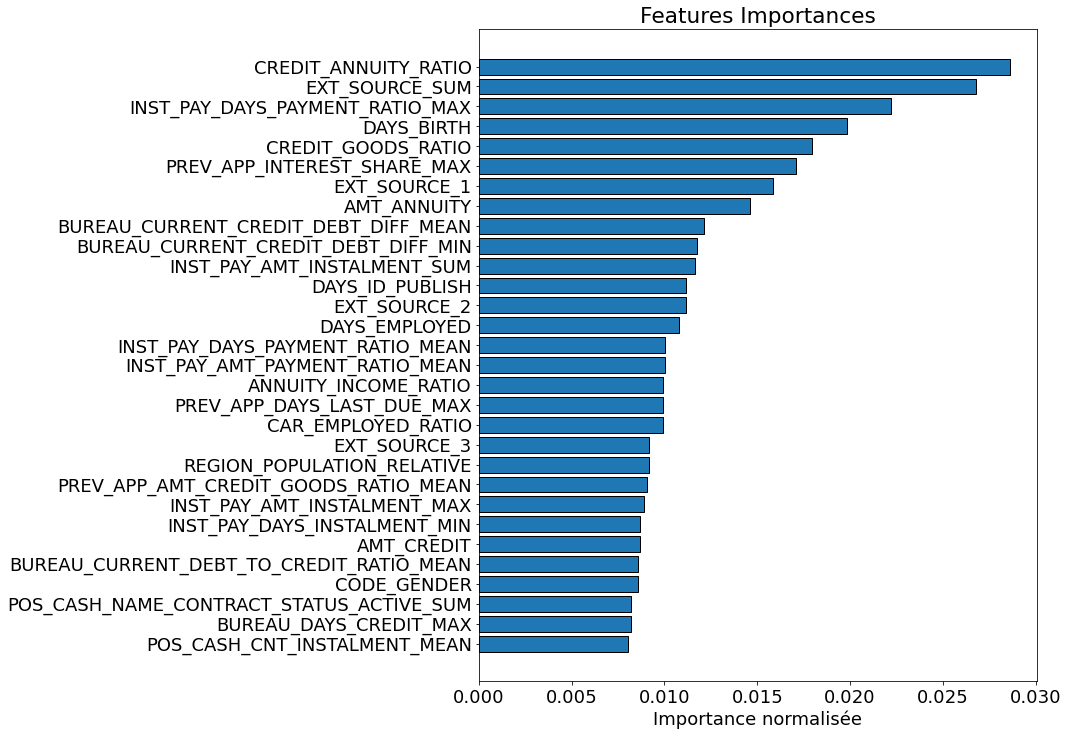

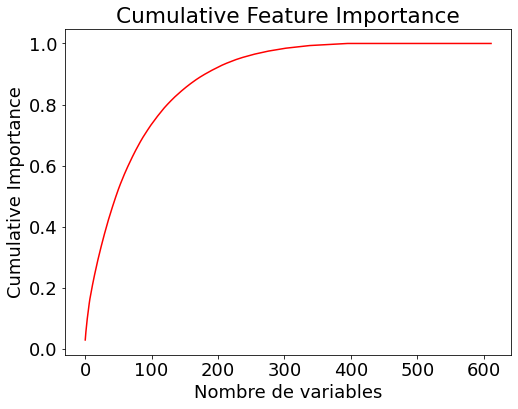

182 variables nécessaires pour 0.90 de cumulative importance


In [260]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = plot_feature_importances(df_fs_lightgbm)

In [261]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 394)
test_fs_lgbm : (48744, 394)


***Second passage***

In [262]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.790085	valid_0's binary_logloss: 0.507205
[200]	valid_0's auc: 0.785571	valid_0's binary_logloss: 0.504752

There are 0 features with 0.0 importance


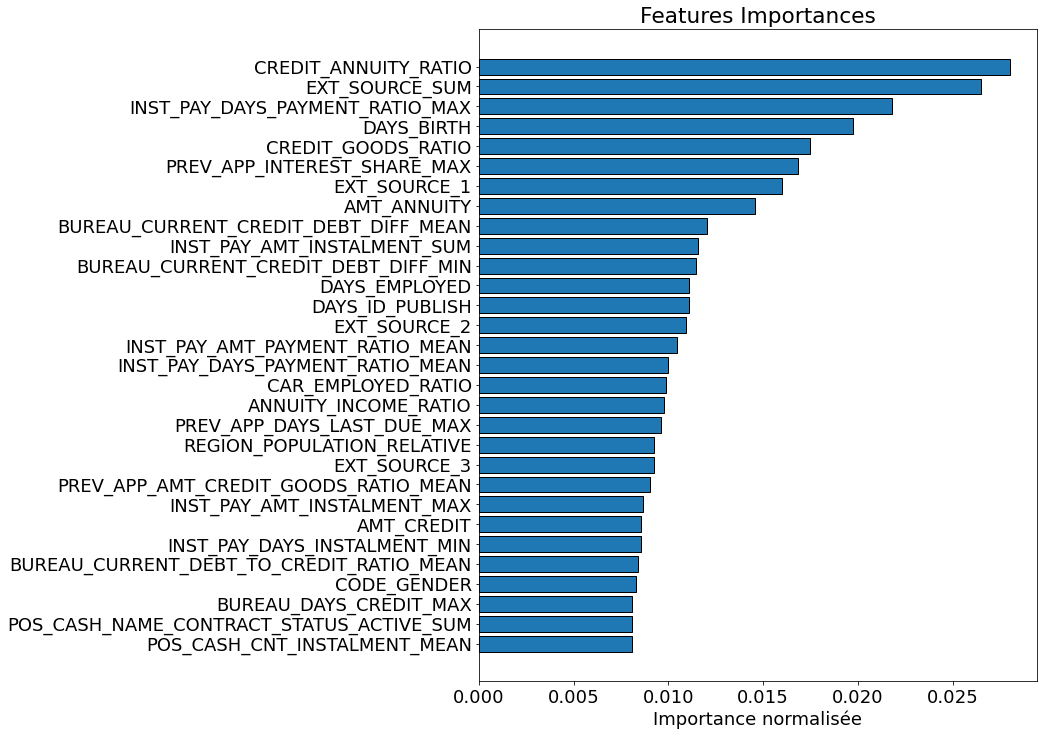

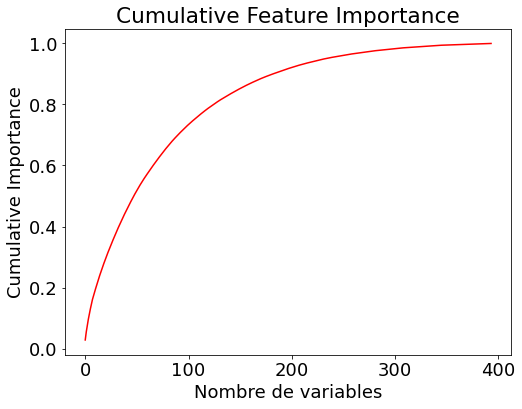

183 variables nécessaires pour 0.90 de cumulative importance


In [263]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = plot_feature_importances(df_fs_lightgbm_2)

In [264]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_2)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_2)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 394)
test_fs_lgbm : (48744, 394)


***Troisième passage***

In [265]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_fs_lightgbm_3 = identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.790085	valid_0's binary_logloss: 0.507205
[200]	valid_0's auc: 0.785571	valid_0's binary_logloss: 0.504752

There are 0 features with 0.0 importance


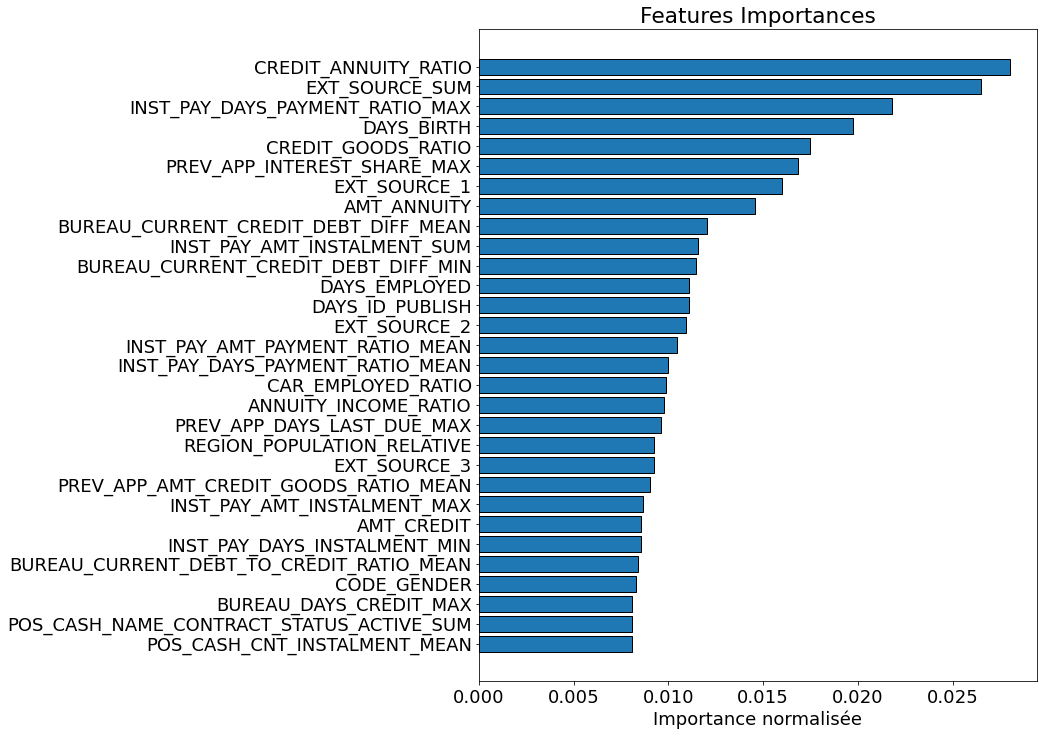

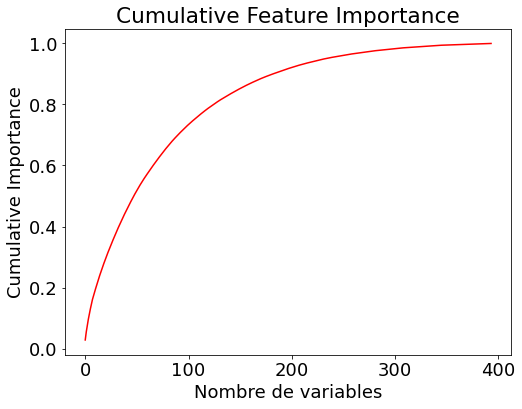

183 variables nécessaires pour 0.90 de cumulative importance


In [266]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_3 = plot_feature_importances(df_fs_lightgbm_3)

In [267]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_3)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_3)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 394)
test_fs_lgbm : (48744, 394)


***Quatrième passage***

In [268]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_4, df_fs_lightgbm_4 = identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.790085	valid_0's binary_logloss: 0.507205
[200]	valid_0's auc: 0.785571	valid_0's binary_logloss: 0.504752

There are 0 features with 0.0 importance


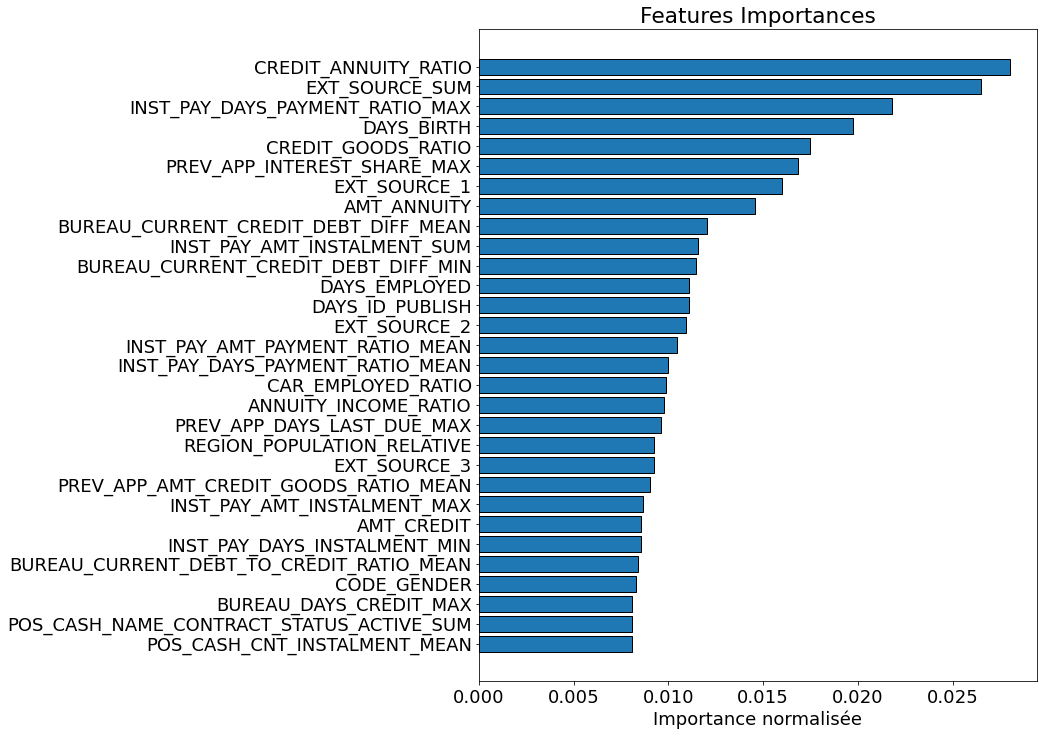

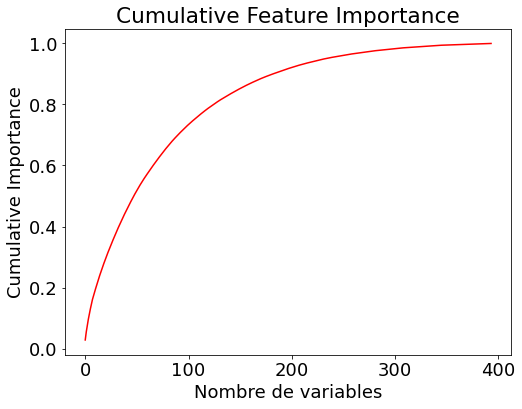

183 variables nécessaires pour 0.90 de cumulative importance


In [269]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_4 = plot_feature_importances(df_fs_lightgbm_4)

In [270]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_4)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_4)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 394)
test_fs_lgbm : (48744, 394)


**Cinquième passage**

In [271]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_5, df_fs_lightgbm_5 = identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.790085	valid_0's binary_logloss: 0.507205
[200]	valid_0's auc: 0.785571	valid_0's binary_logloss: 0.504752

There are 0 features with 0.0 importance


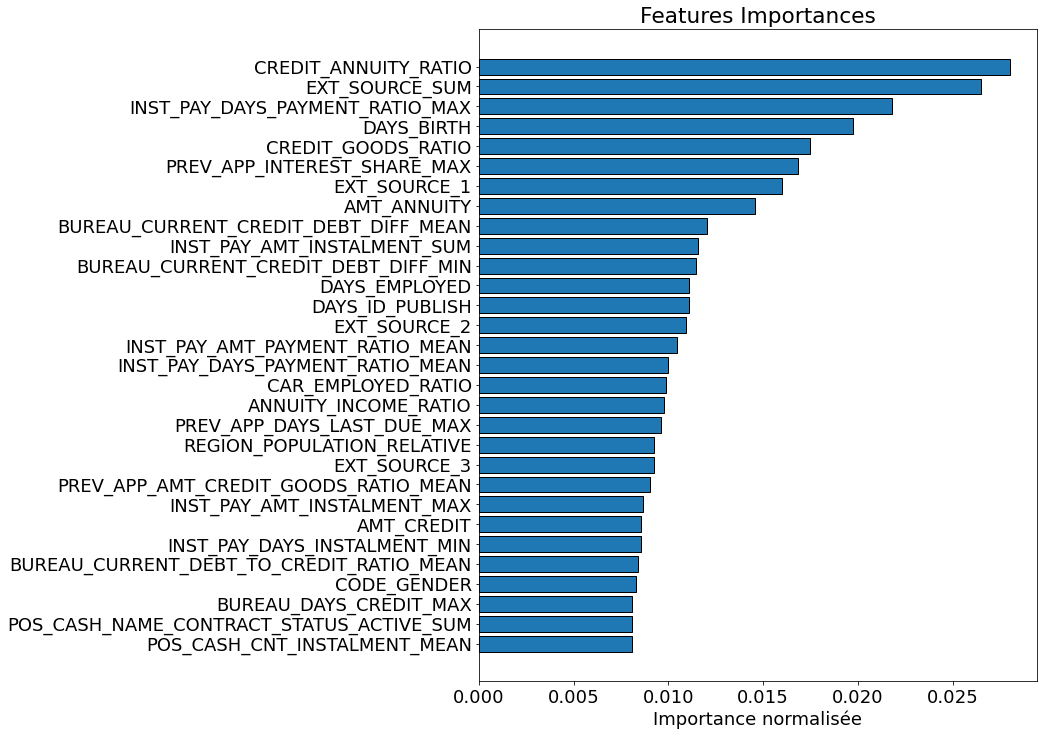

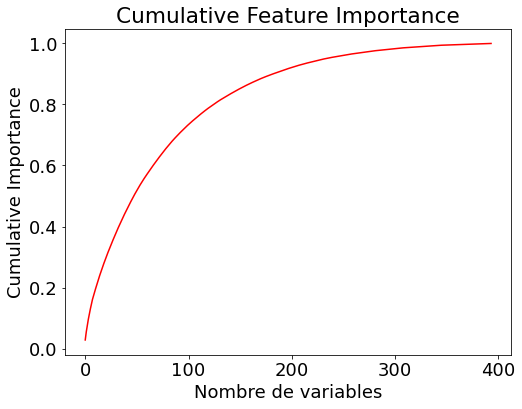

183 variables nécessaires pour 0.90 de cumulative importance


In [272]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_5 = plot_feature_importances(df_fs_lightgbm_5)

In [273]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_5)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_5)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 394)
test_fs_lgbm : (48744, 394)


**Reconstitution des dataframes**

In [274]:
train_fs_lgbm['TARGET'] = train_fs_lgbm_labels
train_fs_lgbm['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 396)
test_fs_lgbm : (48744, 395)


**Sauvegarde**

In [275]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_fs_lightgbm_4, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [276]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_set = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_set, 'rb') as df_fs_train_set:
    df_fs_lightgbm = pickle.load(df_fs_train_set)
df_fs_lightgbm.shape

(394, 2)

In [277]:
df_fs_lightgbm.head()

,feature,importance
50,CREDIT_ANNUITY_RATIO,116.5
59,EXT_SOURCE_SUM,110.0
163,INST_PAY_DAYS_PAYMENT_RATIO_MAX,90.5
9,DAYS_BIRTH,82.0
52,CREDIT_GOODS_RATIO,72.5


In [278]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

train_set - lightgbm : 394 variables importantes conservées


**Dataframe avec threshold = 0.9**

- Il ne reste plus des features d'importance 0. 
- Si nous voulons supprimer plus de features, nous devrons commencer par des features qui ont une importance non nulle. Une façon d'y parvenir consiste à conserver suffisamment de features pour tenir compte d'un seuil pourcentage d'importance, tel que 90 %. 

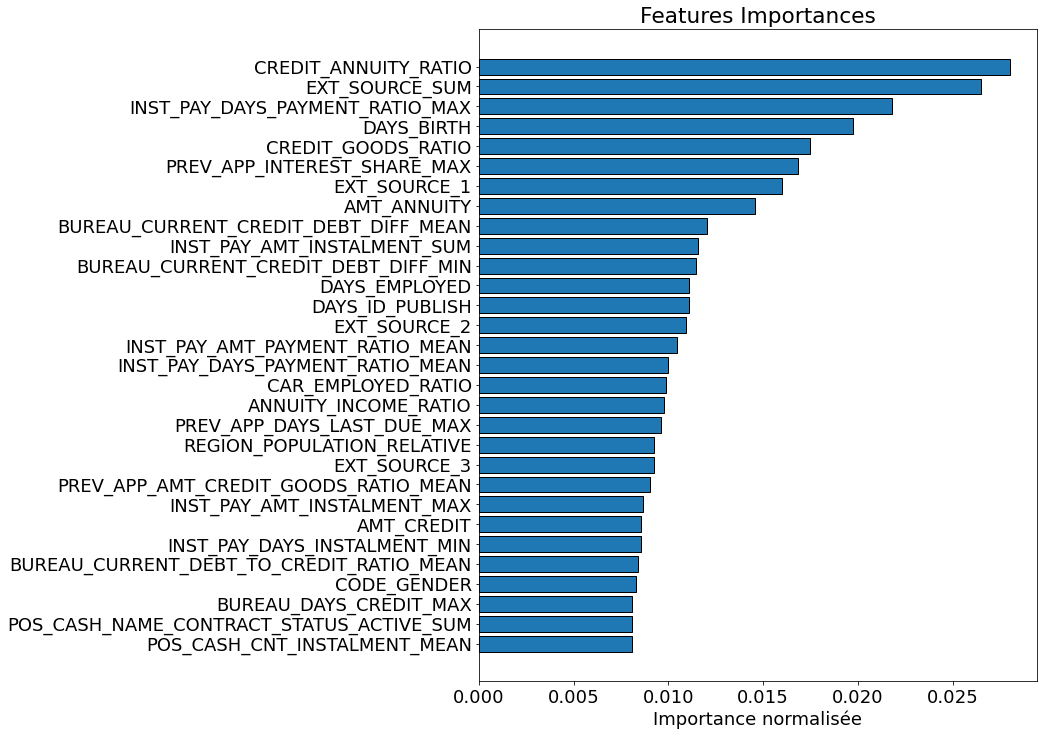

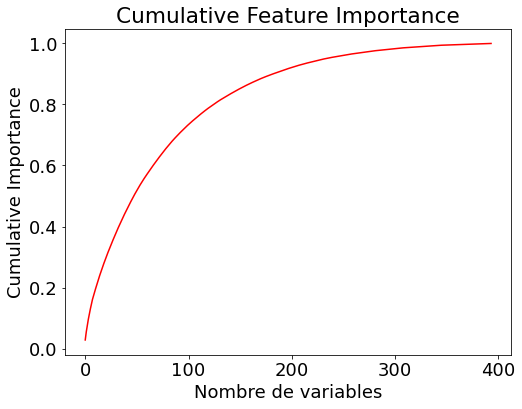

183 variables nécessaires pour 0.90 de cumulative importance


In [279]:
norm_feature_importances = plot_feature_importances(df_fs_lightgbm, threshold = 0.90)

In [280]:
# Threshold for cumulative importance
threshold = 0.90

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train_fs_lgbm[features_to_keep]
test_small = test_fs_lgbm[features_to_keep]

In [281]:
train_small.shape

(307507, 182)

In [282]:
test_small.shape

(48744, 182)

**Reconstitution des dataframes**

In [283]:
train_small['TARGET'] = train_fs_lgbm_labels
train_small['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_small : {train_small.shape}')
test_small['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_small : {test_small.shape}')

train_small : (307507, 184)
test_small : (48744, 183)


**sauvgarde**

In [284]:
# Sauvegarde des features importances avec lightgbm
fic_fs_lightgbm_small = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_fs_lightgbm.pickle'
with open(fic_fs_lightgbm_small, 'wb') as f:
    pickle.dump(train_small, f, pickle.HIGHEST_PROTOCOL)

In [285]:
# Sauvegarde des features importances avec lightgbm
fic_fs_lightgbm_small_test = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_fs_lightgbm.pickle'
with open(fic_fs_lightgbm_small_test, 'wb') as f:
    pickle.dump(test_small, f, pickle.HIGHEST_PROTOCOL)

**Dataframe avec threshold = 0.8**

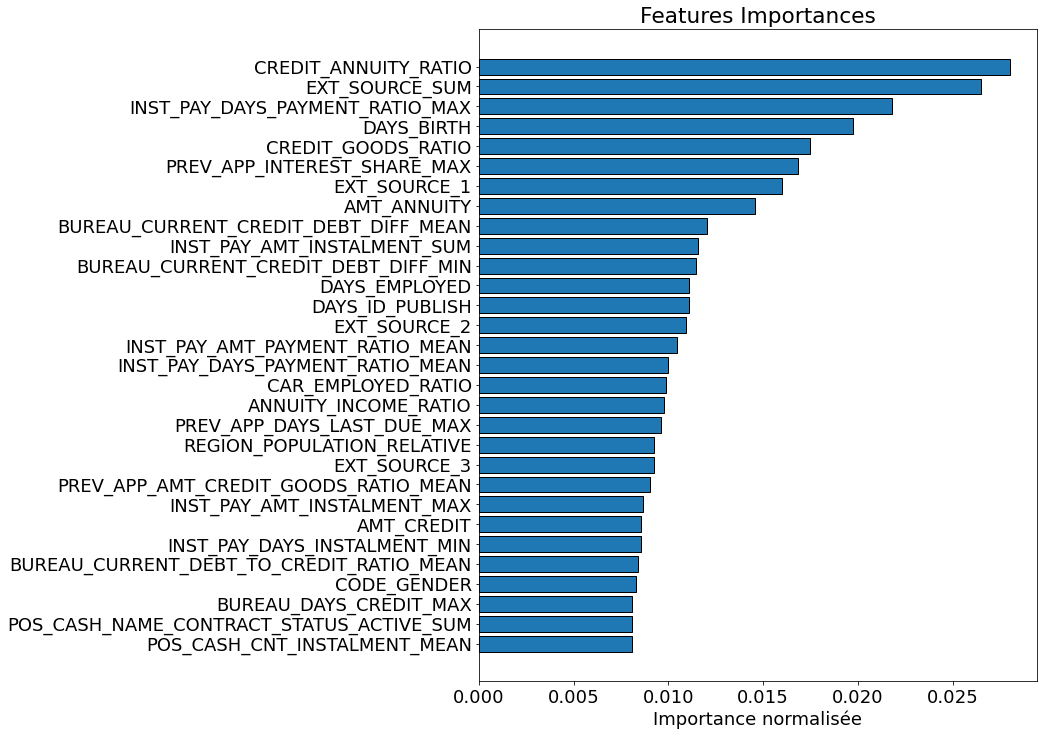

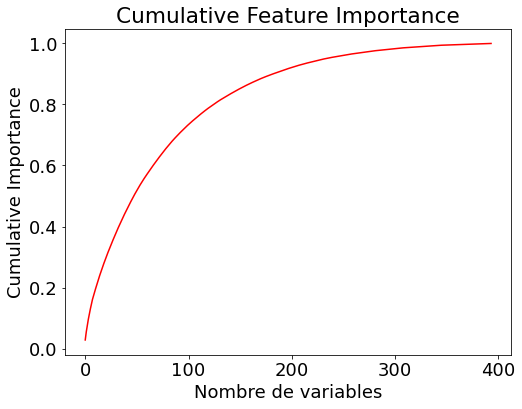

126 variables nécessaires pour 0.80 de cumulative importance


In [286]:
norm_feature_importances = plot_feature_importances(df_fs_lightgbm, threshold = 0.80)

In [287]:
# Threshold for cumulative importance
threshold = 0.80

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_80 = train_fs_lgbm[features_to_keep]
test_80 = test_fs_lgbm[features_to_keep]

In [288]:
# Reconstitutions des dataframes de travail
train_80['TARGET'] = train_fs_lgbm_labels
train_80['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_80 : {train_80.shape}')
test_80['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_80 : {test_80.shape}')

train_80 : (307507, 127)
test_80 : (48744, 126)


**sauvgarde**

In [289]:
# Sauvegarde des features importances avec lightgbm
fic_fs_lightgbm_80 = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_fs_lightgbm_80.pickle'
with open(fic_fs_lightgbm_80, 'wb') as f:
    pickle.dump(train_80, f, pickle.HIGHEST_PROTOCOL)

In [290]:
# Sauvegarde des features importances avec lightgbm
fic_fs_lightgbm_80_test = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_fs_lightgbm_80.pickle'
with open(fic_fs_lightgbm_80_test, 'wb') as f:
    pickle.dump(test_80, f, pickle.HIGHEST_PROTOCOL)

**Bilan**

Dans cette partie, nous avons utilisé un certain nombre de méthodes de sélection de features. Ces méthodes sont nécessaires pour réduire le nombre de features afin d'augmenter l'interprétabilité du modèle, de réduire la durée d'exécution du modèle et d'augmenter les performances de généralisation sur le test set. Les méthodes de sélection des features que nous avons utilisées sont :

- Supprimer les variables hautement colinéaires
- Supprimez toutes les colonnes contenant plus de 68 % de valeurs manquantes.
- Supprimez toutes les features avec une importance nulle telle que déterminée par une algo de renforcement de gradient.
- Ne conservez que suffisamment de features pour représenter 90 % ou 80% de l'importance.